Import important parameter

In [1]:
inputsize = 49
e = 0.0016

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for i in range(outputsize):
            OUTPUT[i][2*i] = 1/4
            OUTPUT[i][1+2*i] = 1/2
            OUTPUT[i][2+2*i] = 1/4
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    outputsize = int(inputsize/2)
    A1 = 2*np.eye(inputsize)
    for i in range(inputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    OUTPUT = A1
    return OUTPUT

def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 2.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 2.*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,2.*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
MAX_ITER = 50
def u_real(x): return np.sin(4.*np.pi*x)
def rightf(x): return  -4*np.pi**2*np.cos(4*np.pi*x)*np.cos(np.pi*x/e)/e+16*(np.pi**2)*(2+np.sin(np.pi*x/e))*np.sin(4*np.pi*x)
def a(x): return 2+np.sin(np.pi*x/e)
outputsize = int(inputsize/2)
h = 1/(inputsize-1)
X = np.linspace(0, 1, inputsize)
H = 1/(outputsize-1)
Media = a(np.linspace(-h,1+h,inputsize+1))
A0 = Poisson(inputsize)
A1 = gallery.divkrad((inputsize,),Media)
RightF = rightf(X)*h**2
RightF = RightF.reshape(inputsize, 1)
UREAL = u_real(X).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 2.*np.transpose(R)

In [5]:
num_levels = 2
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))

Linear = 0.6695275128877841


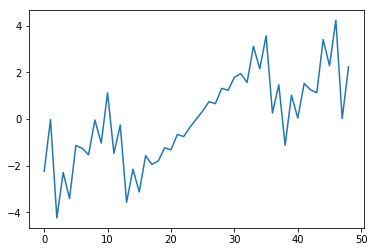

In [6]:
gmmx = linear_gmg.solve(RightF,np.zeros(A1.shape),tol=1e-12)
plt.plot(gmmx)

In [7]:
print("Relative error = {}".format(np.linalg.norm(gmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 2.8848742252862296


Local DMM on fine grid

In [8]:
K = 10
batch_size = 10
num_iter = 4000
step_size = 5e-5
PR_stencil_type = "m3p"
init_point = None
convergence = {}
opt_par_n = {}
conv_time = {}
deep_gmm = dgmg.DeepMG(A1, K=K, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
opt_par = deep_gmm.optimize(num_iter=num_iter, step_size=step_size, batch_size=batch_size, init_point=init_point)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/4000
Upper bound estimation = 0.7311131487774472
Iteration 200/4000
Upper bound estimation = 0.7063169144459607
Iteration 300/4000
Upper bound estimation = 0.6808032436634585
Iteration 400/4000
Upper bound estimation = 0.664358647329727
Iteration 500/4000
Upper bound estimation = 0.6421444894581996
Iteration 600/4000
Upper bound estimation = 0.6129931957914547
Iteration 700/4000
Upper bound estimation = 0.597586479251275
Iteration 800/4000
Upper bound estimation = 0.5817207670504864
Iteration 900/4000
Upper bound estimation = 0.5644903110447175
Iteration 1000/4000
Upper bound estimation = 0.5555538992194407
Iteration 1100/4000
Upper bound estimation = 0.5561443800487852
Iteration 1200/4000
Upper bound estimation = 0.5455398690936547
Iteration 1300/4000
Upper bound estimation = 0.525344269201932
Iteration 1400/4000
Upper bound estimation = 0.5200508718728188
Iteration 1500/4000
Upper bound estimation = 0.5260508103108017
Iteration 1600/4000
Upper bound estimation = 0.49152

In [9]:
deep_gmm.update_prd(opt_par)  
current_rho = deep_gmm.compute_rho()
print("Optimized rho = {}".format(current_rho))

Optimized rho = 0.42997512534860755


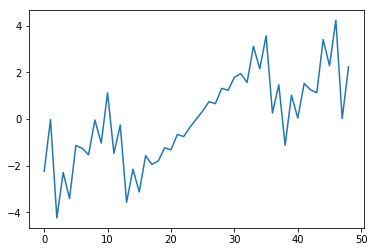

In [10]:
dmmx = deep_gmm.solve(RightF,np.zeros(A1.shape) ,tol=1e-12)
plt.plot(gmmx)

In [11]:
print("Relative error = {}".format(np.linalg.norm(dmmx - UREAL) / 
                                   np.linalg.norm(UREAL)))

Relative error = 2.884874225286907


In [12]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, learning_rate = 1e-6,accept_radius = 1 ,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.11975124641298977
L = 0.03
rho = 0.12122259744691091
L = 0.04
rho = 0.12300466571822695
L = 0.05
rho = 0.1249249316400626
L = 0.060000000000000005
rho = 0.12692454738681397
L = 0.07
rho = 0.12897833602266742
L = 0.08
rho = 0.13107253989583578
L = 0.09
rho = 0.13319821090226996
L = 0.09999999999999999
rho = 0.1353488633750969
L = 0.10999999999999999
rho = 0.1375194860351572
L = 0.11999999999999998
rho = 0.1397060578931397
L = 0.12999999999999998
rho = 0.14190527601708736
L = 0.13999999999999999
rho = 0.14411438372325217
L = 0.15
rho = 0.14633105257091886
L = 0.16
rho = 0.1485532966755593
L = 0.17
rho = 0.15077940829751113
L = 0.18000000000000002
rho = 0.15300790836172548
L = 0.19000000000000003
rho = 0.15523750789191876
L = 0.20000000000000004
rho = 0.15746707762474493
L = 0.21000000000000005
rho = 0.15969562385032168
L = 0.22000000000000006
rho = 0.16192226904053741
L = 0.23000000000000007
rho = 0.16414623618622562
L = 0.24000000000000007
rho = 0.

the 36 steps
rho = 0.3174546780386908
the 37 steps
rho = 0.31744615588402947
the 38 steps
rho = 0.3174377056869031
the 39 steps
rho = 0.3174293265544123
the 40 steps
rho = 0.31742101760617886
the 41 steps
rho = 0.31741277797415285
the 42 steps
rho = 0.3174046068024218
the 43 steps
rho = 0.3173965032470244
the 44 steps
rho = 0.3173884664757665
the 45 steps
rho = 0.3173804956680441
the 46 steps
rho = 0.3173725900146572
the 47 steps
rho = 0.317364748717644
the 48 steps
rho = 0.3173569709901024
the 49 steps
rho = 0.3173492560560229
the 50 steps
rho = 0.31734160315012344
the 51 steps
rho = 0.31733401151767837
the 52 steps
rho = 0.3173264804143684
the 53 steps
rho = 0.31731900910611177
the 54 steps
rho = 0.3173115968689105
the 55 steps
rho = 0.31730424298870075
the 56 steps
rho = 0.317296946761197
the 57 steps
rho = 0.31728970749174246
the 58 steps
rho = 0.31728252449516753
the 59 steps
rho = 0.3172753970956425
the 60 steps
rho = 0.3172683246265354
the 61 steps
rho = 0.3172613064302738
the 6

the 210 steps
rho = 0.31658259332183664
the 211 steps
rho = 0.3165794775773487
the 212 steps
rho = 0.31657637251842663
the 213 steps
rho = 0.3165732780428908
the 214 steps
rho = 0.3165701940496957
the 215 steps
rho = 0.31656712043891805
the 216 steps
rho = 0.3165640571117425
the 217 steps
rho = 0.3165610039704466
the 218 steps
rho = 0.31655796091838984
the 219 steps
rho = 0.31655492786000167
the 220 steps
rho = 0.3165519047007654
the 221 steps
rho = 0.3165488913472084
the 222 steps
rho = 0.31654588770689135
the 223 steps
rho = 0.31654289368838784
the 224 steps
rho = 0.31653990920128355
the 225 steps
rho = 0.3165369341561554
the 226 steps
rho = 0.3165339684645657
the 227 steps
rho = 0.3165310120390465
the 228 steps
rho = 0.3165280647930903
the 229 steps
rho = 0.31652512664113686
the 230 steps
rho = 0.31652219749856547
the 231 steps
rho = 0.3165192772816807
the 232 steps
rho = 0.31651636590770255
the 233 steps
rho = 0.31651346329475555
the 234 steps
rho = 0.31651056936185945
the 235 step

the 384 steps
rho = 0.3161425788584218
the 385 steps
rho = 0.31614042003681103
the 386 steps
rho = 0.31613826382370586
the 387 steps
rho = 0.31613611020254273
the 388 steps
rho = 0.31613395915691567
the 389 steps
rho = 0.3161318106705788
the 390 steps
rho = 0.3161296647274438
the 391 steps
rho = 0.31612752131157573
the 392 steps
rho = 0.31612538040719546
the 393 steps
rho = 0.3161232419986742
the 394 steps
rho = 0.3161211060705353
the 395 steps
rho = 0.3161189726074496
the 396 steps
rho = 0.31611684159423586
the 397 steps
rho = 0.31611471301585875
the 398 steps
rho = 0.31611258685742705
the 399 steps
rho = 0.31611046310419083
the 400 steps
rho = 0.3161083417415419
the 401 steps
rho = 0.3161062227550142
the 402 steps
rho = 0.3161041061302762
the 403 steps
rho = 0.316101991853134
the 404 steps
rho = 0.31609987990953153
the 405 steps
rho = 0.316097770285543
the 406 steps
rho = 0.3160956629673747
the 407 steps
rho = 0.3160935579413677
the 408 steps
rho = 0.316091455193989
the 409 steps
rho

the 557 steps
rho = 0.315798064920398
the 558 steps
rho = 0.31579620257870517
the 559 steps
rho = 0.31579434140024476
the 560 steps
rho = 0.3157924813812865
the 561 steps
rho = 0.3157906225181309
the 562 steps
rho = 0.31578876480709966
the 563 steps
rho = 0.3157869082445456
the 564 steps
rho = 0.3157850528268433
the 565 steps
rho = 0.3157831985503969
the 566 steps
rho = 0.3157813454116328
the 567 steps
rho = 0.31577949340700545
the 568 steps
rho = 0.31577764253299023
the 569 steps
rho = 0.31577579278609347
the 570 steps
rho = 0.31577394416283805
the 571 steps
rho = 0.315772096659781
the 572 steps
rho = 0.31577025027349387
the 573 steps
rho = 0.31576840500057785
the 574 steps
rho = 0.31576656083765603
the 575 steps
rho = 0.31576471778137394
the 576 steps
rho = 0.31576287582840173
the 577 steps
rho = 0.3157610349754307
the 578 steps
rho = 0.3157591952191784
the 579 steps
rho = 0.3157573565563811
the 580 steps
rho = 0.3157555189837981
the 581 steps
rho = 0.31575368249821145
the 582 steps


the 731 steps
rho = 0.3154890439373301
the 732 steps
rho = 0.3154873439561844
the 733 steps
rho = 0.31548564474009005
the 734 steps
rho = 0.31548394628762977
the 735 steps
rho = 0.31548224859739404
the 736 steps
rho = 0.3154805516679761
the 737 steps
rho = 0.31547885549797683
the 738 steps
rho = 0.3154771600860018
the 739 steps
rho = 0.3154754654306626
the 740 steps
rho = 0.3154737715305756
the 741 steps
rho = 0.31547207838436253
the 742 steps
rho = 0.3154703859906529
the 743 steps
rho = 0.315468694348078
the 744 steps
rho = 0.31546700345527606
the 745 steps
rho = 0.31546531331089334
the 746 steps
rho = 0.315463623913575
the 747 steps
rho = 0.3154619352619777
the 748 steps
rho = 0.3154602473547596
the 749 steps
rho = 0.3154585601905849
the 750 steps
rho = 0.31545687376812337
the 751 steps
rho = 0.31545518808605183
the 752 steps
rho = 0.31545350314304627
the 753 steps
rho = 0.31545181893779234
the 754 steps
rho = 0.31545013546898176
the 755 steps
rho = 0.31544845273530564
the 756 steps


the 908 steps
rho = 0.31519895566778466
the 909 steps
rho = 0.3151973729423606
the 910 steps
rho = 0.3151957907927749
the 911 steps
rho = 0.3151942092182051
the 912 steps
rho = 0.3151926282178252
the 913 steps
rho = 0.3151910477908178
the 914 steps
rho = 0.315189467936364
the 915 steps
rho = 0.3151878886536457
the 916 steps
rho = 0.3151863099418493
the 917 steps
rho = 0.31518473180016354
the 918 steps
rho = 0.3151831542277747
the 919 steps
rho = 0.31518157722387535
the 920 steps
rho = 0.3151800007876584
the 921 steps
rho = 0.3151784249183187
the 922 steps
rho = 0.31517684961505354
the 923 steps
rho = 0.31517527487705954
the 924 steps
rho = 0.315173700703539
the 925 steps
rho = 0.315172127093692
the 926 steps
rho = 0.31517055404672484
the 927 steps
rho = 0.31516898156184114
the 928 steps
rho = 0.315167409638249
the 929 steps
rho = 0.31516583827516026
the 930 steps
rho = 0.31516426747178217
the 931 steps
rho = 0.3151626972273308
the 932 steps
rho = 0.3151611275410185
the 933 steps
rho = 

the 1047 steps
rho = 0.31498414454004214
the 1048 steps
rho = 0.3149826346912523
the 1049 steps
rho = 0.3149811253192631
the 1050 steps
rho = 0.3149796164234575
the 1051 steps
rho = 0.3149781080032177
the 1052 steps
rho = 0.3149766000579309
the 1053 steps
rho = 0.3149750925869822
the 1054 steps
rho = 0.31497358558975813
the 1055 steps
rho = 0.31497207906564995
the 1056 steps
rho = 0.3149705730140443
the 1057 steps
rho = 0.3149690674343332
the 1058 steps
rho = 0.3149675623259103
the 1059 steps
rho = 0.3149660576881658
the 1060 steps
rho = 0.3149645535204954
the 1061 steps
rho = 0.3149630498222944
the 1062 steps
rho = 0.31496154659295866
the 1063 steps
rho = 0.3149600438318859
the 1064 steps
rho = 0.31495854153847536
the 1065 steps
rho = 0.3149570397121266
the 1066 steps
rho = 0.3149555383522395
the 1067 steps
rho = 0.3149540374582179
the 1068 steps
rho = 0.31495253702946213
the 1069 steps
rho = 0.3149510370653779
the 1070 steps
rho = 0.3149495375653714
the 1071 steps
rho = 0.31494803852

the 1218 steps
rho = 0.3147324214895122
the 1219 steps
rho = 0.3147309850447998
the 1220 steps
rho = 0.31472954898576416
the 1221 steps
rho = 0.314728113311949
the 1222 steps
rho = 0.31472667802289256
the 1223 steps
rho = 0.31472524311814054
the 1224 steps
rho = 0.3147238085972332
the 1225 steps
rho = 0.3147223744597156
the 1226 steps
rho = 0.31472094070513207
the 1227 steps
rho = 0.3147195073330282
the 1228 steps
rho = 0.31471807434294946
the 1229 steps
rho = 0.31471664173444225
the 1230 steps
rho = 0.3147152095070559
the 1231 steps
rho = 0.3147137776603352
the 1232 steps
rho = 0.31471234619383215
the 1233 steps
rho = 0.3147109151070943
the 1234 steps
rho = 0.31470948439967406
the 1235 steps
rho = 0.3147080540711203
the 1236 steps
rho = 0.31470662412098593
the 1237 steps
rho = 0.31470519454882395
the 1238 steps
rho = 0.31470376535418615
the 1239 steps
rho = 0.3147023365366269
the 1240 steps
rho = 0.3147009080957021
the 1241 steps
rho = 0.3146994800309656
the 1242 steps
rho = 0.3146980

the 1354 steps
rho = 0.3145404268183809
the 1355 steps
rho = 0.3145390388943514
the 1356 steps
rho = 0.3145376512997593
the 1357 steps
rho = 0.3145362640342339
the 1358 steps
rho = 0.3145348770974008
the 1359 steps
rho = 0.31453349048889256
the 1360 steps
rho = 0.31453210420833805
the 1361 steps
rho = 0.314530718255368
the 1362 steps
rho = 0.31452933262961386
the 1363 steps
rho = 0.314527947330709
the 1364 steps
rho = 0.31452656235828524
the 1365 steps
rho = 0.3145251777119744
the 1366 steps
rho = 0.31452379339141157
the 1367 steps
rho = 0.314522409396231
the 1368 steps
rho = 0.3145210257260667
the 1369 steps
rho = 0.3145196423805536
the 1370 steps
rho = 0.3145182593593286
the 1371 steps
rho = 0.31451687666202693
the 1372 steps
rho = 0.3145154942882861
the 1373 steps
rho = 0.314514112237743
the 1374 steps
rho = 0.314512730510037
the 1375 steps
rho = 0.31451134910480477
the 1376 steps
rho = 0.31450996802168685
the 1377 steps
rho = 0.3145085872603212
the 1378 steps
rho = 0.31450720682035

the 1492 steps
rho = 0.3143518560076563
the 1493 steps
rho = 0.31435051026023875
the 1494 steps
rho = 0.31434916479586783
the 1495 steps
rho = 0.31434781961423935
the 1496 steps
rho = 0.31434647471505034
the 1497 steps
rho = 0.314345130098
the 1498 steps
rho = 0.3143437857627828
the 1499 steps
rho = 0.31434244170910075
the 1500 steps
rho = 0.31434109793664955
the 1501 steps
rho = 0.3143397544451305
the 1502 steps
rho = 0.3143384112342422
the 1503 steps
rho = 0.314337068303686
the 1504 steps
rho = 0.3143357256531611
the 1505 steps
rho = 0.31433438328236957
the 1506 steps
rho = 0.3143330411910113
the 1507 steps
rho = 0.3143316993787879
the 1508 steps
rho = 0.314330357845404
the 1509 steps
rho = 0.3143290165905594
the 1510 steps
rho = 0.314327675613959
the 1511 steps
rho = 0.314326334915305
the 1512 steps
rho = 0.3143249944943025
the 1513 steps
rho = 0.3143236543506552
the 1514 steps
rho = 0.31432231448406756
the 1515 steps
rho = 0.3143209748942454
the 1516 steps
rho = 0.31431963558089304

the 1630 steps
rho = 0.31416869445910095
the 1631 steps
rho = 0.31416738507895636
the 1632 steps
rho = 0.3141660759437704
the 1633 steps
rho = 0.3141647670532928
the 1634 steps
rho = 0.31416345840727394
the 1635 steps
rho = 0.3141621500054636
the 1636 steps
rho = 0.3141608418476136
the 1637 steps
rho = 0.3141595339334733
the 1638 steps
rho = 0.314158226262796
the 1639 steps
rho = 0.31415691883533026
the 1640 steps
rho = 0.3141556116508317
the 1641 steps
rho = 0.3141543047090509
the 1642 steps
rho = 0.31415299800974095
the 1643 steps
rho = 0.31415169155265377
the 1644 steps
rho = 0.3141503853375433
the 1645 steps
rho = 0.31414907936416525
the 1646 steps
rho = 0.31414777363227075
the 1647 steps
rho = 0.31414646814161573
the 1648 steps
rho = 0.31414516289195404
the 1649 steps
rho = 0.3141438578830415
the 1650 steps
rho = 0.314142553114634
the 1651 steps
rho = 0.3141412485864841
the 1652 steps
rho = 0.3141399442983524
the 1653 steps
rho = 0.31413864024999205
the 1654 steps
rho = 0.31413733

the 1767 steps
rho = 0.31399149103761914
the 1768 steps
rho = 0.31399021301957897
the 1769 steps
rho = 0.3139889352151453
the 1770 steps
rho = 0.3139876576241075
the 1771 steps
rho = 0.313986380246259
the 1772 steps
rho = 0.31398510308139194
the 1773 steps
rho = 0.3139838261292976
the 1774 steps
rho = 0.31398254938977027
the 1775 steps
rho = 0.3139812728625993
the 1776 steps
rho = 0.3139799965475809
the 1777 steps
rho = 0.3139787204445062
the 1778 steps
rho = 0.31397744455317145
the 1779 steps
rho = 0.3139761688733666
the 1780 steps
rho = 0.31397489340488993
the 1781 steps
rho = 0.3139736181475309
the 1782 steps
rho = 0.313972343101088
the 1783 steps
rho = 0.31397106826535554
the 1784 steps
rho = 0.31396979364012806
the 1785 steps
rho = 0.3139685192252015
the 1786 steps
rho = 0.313967245020371
the 1787 steps
rho = 0.31396597102543117
the 1788 steps
rho = 0.3139646972401814
the 1789 steps
rho = 0.313963423664416
the 1790 steps
rho = 0.3139621502979311
the 1791 steps
rho = 0.313960877140

the 1937 steps
rho = 0.3137771372748536
the 1938 steps
rho = 0.3137758927781178
the 1939 steps
rho = 0.3137746484631072
the 1940 steps
rho = 0.31377340432965317
the 1941 steps
rho = 0.3137721603775873
the 1942 steps
rho = 0.313770916606745
the 1943 steps
rho = 0.3137696730169555
the 1944 steps
rho = 0.3137684296080536
the 1945 steps
rho = 0.31376718637986983
the 1946 steps
rho = 0.31376594333224145
the 1947 steps
rho = 0.31376470046499777
the 1948 steps
rho = 0.3137634577779759
the 1949 steps
rho = 0.3137622152710069
the 1950 steps
rho = 0.31376097294392674
the 1951 steps
rho = 0.3137597307965697
the 1952 steps
rho = 0.3137584888287686
the 1953 steps
rho = 0.31375724704035934
the 1954 steps
rho = 0.31375600543117776
the 1955 steps
rho = 0.31375476400105723
the 1956 steps
rho = 0.3137535227498333
the 1957 steps
rho = 0.31375228167734237
the 1958 steps
rho = 0.3137510407834201
the 1959 steps
rho = 0.3137498000679009
the 1960 steps
rho = 0.3137485595306237
the 1961 steps
rho = 0.313747319

the 2075 steps
rho = 0.31360704548225266
the 2076 steps
rho = 0.31360582456068536
the 2077 steps
rho = 0.3136046037995085
the 2078 steps
rho = 0.31360338319857994
the 2079 steps
rho = 0.3136021627577571
the 2080 steps
rho = 0.3136009424768992
the 2081 steps
rho = 0.3135997223558656
the 2082 steps
rho = 0.3135985023945142
the 2083 steps
rho = 0.31359728259270386
the 2084 steps
rho = 0.31359606295029374
the 2085 steps
rho = 0.31359484346714356
the 2086 steps
rho = 0.31359362414311187
the 2087 steps
rho = 0.31359240497805935
the 2088 steps
rho = 0.3135911859718457
the 2089 steps
rho = 0.3135899671243294
the 2090 steps
rho = 0.3135887484353732
the 2091 steps
rho = 0.31358752990483596
the 2092 steps
rho = 0.31358631153257643
the 2093 steps
rho = 0.3135850933184591
the 2094 steps
rho = 0.31358387526234055
the 2095 steps
rho = 0.3135826573640857
the 2096 steps
rho = 0.313581439623554
the 2097 steps
rho = 0.31358022204060476
the 2098 steps
rho = 0.3135790046151029
the 2099 steps
rho = 0.313577

the 2252 steps
rho = 0.31339331810032967
the 2253 steps
rho = 0.31339212350355794
the 2254 steps
rho = 0.3133909290445119
the 2255 steps
rho = 0.313389734723075
the 2256 steps
rho = 0.3133885405391358
the 2257 steps
rho = 0.31338734649257455
the 2258 steps
rho = 0.31338615258327934
the 2259 steps
rho = 0.3133849588111363
the 2260 steps
rho = 0.3133837651760296
the 2261 steps
rho = 0.3133825716778442
the 2262 steps
rho = 0.31338137831646723
the 2263 steps
rho = 0.3133801850917834
the 2264 steps
rho = 0.3133789920036802
the 2265 steps
rho = 0.3133777990520432
the 2266 steps
rho = 0.3133766062367574
the 2267 steps
rho = 0.31337541355771054
the 2268 steps
rho = 0.31337422101478923
the 2269 steps
rho = 0.31337302860788085
the 2270 steps
rho = 0.3133718363368703
the 2271 steps
rho = 0.3133706442016458
the 2272 steps
rho = 0.31336945220209356
the 2273 steps
rho = 0.313368260338102
the 2274 steps
rho = 0.31336706860955643
the 2275 steps
rho = 0.31336587701634816
the 2276 steps
rho = 0.31336468

the 2422 steps
rho = 0.3131921267132889
the 2423 steps
rho = 0.31319095397686564
the 2424 steps
rho = 0.31318978136036557
the 2425 steps
rho = 0.31318860886369515
the 2426 steps
rho = 0.31318743648675695
the 2427 steps
rho = 0.3131862642294583
the 2428 steps
rho = 0.3131850920917041
the 2429 steps
rho = 0.3131839200733995
the 2430 steps
rho = 0.3131827481744505
the 2431 steps
rho = 0.31318157639476335
the 2432 steps
rho = 0.31318040473424197
the 2433 steps
rho = 0.3131792331927938
the 2434 steps
rho = 0.31317806177032526
the 2435 steps
rho = 0.31317689046674146
the 2436 steps
rho = 0.3131757192819483
the 2437 steps
rho = 0.3131745482158525
the 2438 steps
rho = 0.31317337726836136
the 2439 steps
rho = 0.3131722064393799
the 2440 steps
rho = 0.313171035728817
the 2441 steps
rho = 0.3131698651365782
the 2442 steps
rho = 0.3131686946625692
the 2443 steps
rho = 0.31316752430669814
the 2444 steps
rho = 0.3131663540688725
the 2445 steps
rho = 0.3131651839489994
the 2446 steps
rho = 0.31316401

the 2559 steps
rho = 0.3130325406727716
the 2560 steps
rho = 0.31303138352407095
the 2561 steps
rho = 0.313030226483222
the 2562 steps
rho = 0.31302906955014026
the 2563 steps
rho = 0.31302791272474695
the 2564 steps
rho = 0.31302675600695806
the 2565 steps
rho = 0.3130255993966947
the 2566 steps
rho = 0.3130244428938742
the 2567 steps
rho = 0.31302328649841415
the 2568 steps
rho = 0.31302213021023717
the 2569 steps
rho = 0.31302097402925877
the 2570 steps
rho = 0.3130198179554006
the 2571 steps
rho = 0.3130186619885795
the 2572 steps
rho = 0.313017506128716
the 2573 steps
rho = 0.31301635037572845
the 2574 steps
rho = 0.31301519472953826
the 2575 steps
rho = 0.3130140391900641
the 2576 steps
rho = 0.31301288375722414
the 2577 steps
rho = 0.3130117284309396
the 2578 steps
rho = 0.3130105732111299
the 2579 steps
rho = 0.31300941809771476
the 2580 steps
rho = 0.3130082630906146
the 2581 steps
rho = 0.3130071081897493
the 2582 steps
rho = 0.3130059533950384
the 2583 steps
rho = 0.31300479

the 2728 steps
rho = 0.3128384518811215
the 2729 steps
rho = 0.3128373118670928
the 2730 steps
rho = 0.3128361719482982
the 2731 steps
rho = 0.3128350321246677
the 2732 steps
rho = 0.3128338923961329
the 2733 steps
rho = 0.31283275276262756
the 2734 steps
rho = 0.3128316132240847
the 2735 steps
rho = 0.31283047378043455
the 2736 steps
rho = 0.3128293344316091
the 2737 steps
rho = 0.3128281951775428
the 2738 steps
rho = 0.31282705601816474
the 2739 steps
rho = 0.3128259169534105
the 2740 steps
rho = 0.31282477798321195
the 2741 steps
rho = 0.31282363910750066
the 2742 steps
rho = 0.31282250032621056
the 2743 steps
rho = 0.3128213616392731
the 2744 steps
rho = 0.3128202230466216
the 2745 steps
rho = 0.3128190845481895
the 2746 steps
rho = 0.31281794614390945
the 2747 steps
rho = 0.31281680783371363
the 2748 steps
rho = 0.3128156696175377
the 2749 steps
rho = 0.31281453149531185
the 2750 steps
rho = 0.3128133934669713
the 2751 steps
rho = 0.3128122555324478
the 2752 steps
rho = 0.31281111

the 2864 steps
rho = 0.3126842572386928
the 2865 steps
rho = 0.31268312957953
the 2866 steps
rho = 0.3126820020069645
the 2867 steps
rho = 0.3126808745209356
the 2868 steps
rho = 0.3126797471213861
the 2869 steps
rho = 0.3126786198082559
the 2870 steps
rho = 0.3126774925814877
the 2871 steps
rho = 0.31267636544102084
the 2872 steps
rho = 0.31267523838679845
the 2873 steps
rho = 0.31267411141875817
the 2874 steps
rho = 0.31267298453684705
the 2875 steps
rho = 0.3126718577410008
the 2876 steps
rho = 0.31267073103116555
the 2877 steps
rho = 0.31266960440727887
the 2878 steps
rho = 0.31266847786928426
the 2879 steps
rho = 0.31266735141712454
the 2880 steps
rho = 0.3126662250507381
the 2881 steps
rho = 0.3126650987700696
the 2882 steps
rho = 0.31266397257506046
the 2883 steps
rho = 0.3126628464656519
the 2884 steps
rho = 0.3126617204417851
the 2885 steps
rho = 0.31266059450340306
the 2886 steps
rho = 0.31265946865044975
the 2887 steps
rho = 0.312658342882862
the 2888 steps
rho = 0.312657217

the 3001 steps
rho = 0.31253055072926944
the 3002 steps
rho = 0.31252943440798564
the 3003 steps
rho = 0.3125283181657429
the 3004 steps
rho = 0.3125272020024878
the 3005 steps
rho = 0.3125260859181714
the 3006 steps
rho = 0.3125249699127407
the 3007 steps
rho = 0.3125238539861449
the 3008 steps
rho = 0.312522738138333
the 3009 steps
rho = 0.3125216223692547
the 3010 steps
rho = 0.3125205066788585
the 3011 steps
rho = 0.31251939106709126
the 3012 steps
rho = 0.31251827553390504
the 3013 steps
rho = 0.3125171600792475
the 3014 steps
rho = 0.3125160447030673
the 3015 steps
rho = 0.31251492940531467
the 3016 steps
rho = 0.31251381418593854
the 3017 steps
rho = 0.31251269904488777
the 3018 steps
rho = 0.312511583982113
the 3019 steps
rho = 0.3125104689975615
the 3020 steps
rho = 0.312509354091184
the 3021 steps
rho = 0.31250823926293064
the 3022 steps
rho = 0.31250712451274953
the 3023 steps
rho = 0.3125060098405907
the 3024 steps
rho = 0.3125048952464037
the 3025 steps
rho = 0.31250378073

the 3172 steps
rho = 0.31234076828289004
the 3173 steps
rho = 0.31233966477107467
the 3174 steps
rho = 0.31233856133021787
the 3175 steps
rho = 0.3123374579602779
the 3176 steps
rho = 0.3123363546612096
the 3177 steps
rho = 0.3123352514329737
the 3178 steps
rho = 0.31233414827552275
the 3179 steps
rho = 0.3123330451888163
the 3180 steps
rho = 0.31233194217280896
the 3181 steps
rho = 0.31233083922745947
the 3182 steps
rho = 0.31232973635272404
the 3183 steps
rho = 0.3123286335485598
the 3184 steps
rho = 0.3123275308149245
the 3185 steps
rho = 0.31232642815177325
the 3186 steps
rho = 0.31232532555906545
the 3187 steps
rho = 0.31232422303675633
the 3188 steps
rho = 0.31232312058480494
the 3189 steps
rho = 0.3123220182031673
the 3190 steps
rho = 0.31232091589180166
the 3191 steps
rho = 0.3123198136506616
the 3192 steps
rho = 0.3123187114797109
the 3193 steps
rho = 0.3123176093789016
the 3194 steps
rho = 0.31231650734819394
the 3195 steps
rho = 0.3123154053875452
the 3196 steps
rho = 0.3123

the 3312 steps
rho = 0.3121869482985751
the 3313 steps
rho = 0.3121858543176829
the 3314 steps
rho = 0.31218476040207704
the 3315 steps
rho = 0.3121836665517156
the 3316 steps
rho = 0.31218257276656375
the 3317 steps
rho = 0.3121814790465828
the 3318 steps
rho = 0.3121803853917347
the 3319 steps
rho = 0.31217929180198195
the 3320 steps
rho = 0.31217819827728727
the 3321 steps
rho = 0.31217710481761246
the 3322 steps
rho = 0.3121760114229213
the 3323 steps
rho = 0.31217491809317366
the 3324 steps
rho = 0.3121738248283342
the 3325 steps
rho = 0.312172731628365
the 3326 steps
rho = 0.3121716384932277
the 3327 steps
rho = 0.3121705454228858
the 3328 steps
rho = 0.3121694524173034
the 3329 steps
rho = 0.3121683594764396
the 3330 steps
rho = 0.31216726660025895
the 3331 steps
rho = 0.31216617378872463
the 3332 steps
rho = 0.31216508104179885
the 3333 steps
rho = 0.31216398835944437
the 3334 steps
rho = 0.31216289574162487
the 3335 steps
rho = 0.3121618031883034
the 3336 steps
rho = 0.3121607

the 3454 steps
rho = 0.31203223946712694
the 3455 steps
rho = 0.31203115439412454
the 3456 steps
rho = 0.3120300693813798
the 3457 steps
rho = 0.31202898442885807
the 3458 steps
rho = 0.31202789953652676
the 3459 steps
rho = 0.3120268147043518
the 3460 steps
rho = 0.31202572993230154
the 3461 steps
rho = 0.31202464522034307
the 3462 steps
rho = 0.31202356056844444
the 3463 steps
rho = 0.31202247597657007
the 3464 steps
rho = 0.3120213914446889
the 3465 steps
rho = 0.3120203069727674
the 3466 steps
rho = 0.312019222560773
the 3467 steps
rho = 0.31201813820867424
the 3468 steps
rho = 0.31201705391643636
the 3469 steps
rho = 0.3120159696840283
the 3470 steps
rho = 0.3120148855114165
the 3471 steps
rho = 0.3120138013985677
the 3472 steps
rho = 0.31201271734545066
the 3473 steps
rho = 0.312011633352032
the 3474 steps
rho = 0.31201054941827866
the 3475 steps
rho = 0.3120094655441604
the 3476 steps
rho = 0.3120083817296421
the 3477 steps
rho = 0.3120072979746921
the 3478 steps
rho = 0.3120062

the 3596 steps
rho = 0.3118787473702358
the 3597 steps
rho = 0.31187767053660503
the 3598 steps
rho = 0.31187659375883203
the 3599 steps
rho = 0.31187551703688643
the 3600 steps
rho = 0.31187444037073786
the 3601 steps
rho = 0.31187336376036146
the 3602 steps
rho = 0.31187228720572463
the 3603 steps
rho = 0.31187121070680135
the 3604 steps
rho = 0.3118701342635592
the 3605 steps
rho = 0.31186905787597435
the 3606 steps
rho = 0.31186798154401313
the 3607 steps
rho = 0.31186690526764876
the 3608 steps
rho = 0.31186582904685306
the 3609 steps
rho = 0.3118647528815962
the 3610 steps
rho = 0.31186367677185034
the 3611 steps
rho = 0.3118626007175877
the 3612 steps
rho = 0.311861524718777
the 3613 steps
rho = 0.31186044877539226
the 3614 steps
rho = 0.31185937288740306
the 3615 steps
rho = 0.31185829705478146
the 3616 steps
rho = 0.3118572212774994
the 3617 steps
rho = 0.3118561455555269
the 3618 steps
rho = 0.31185506988883827
the 3619 steps
rho = 0.31185399427740196
the 3620 steps
rho = 0.3

the 3739 steps
rho = 0.31172531387772806
the 3740 steps
rho = 0.31172424474963123
the 3741 steps
rho = 0.3117231756735027
the 3742 steps
rho = 0.3117221066493207
the 3743 steps
rho = 0.3117210376770567
the 3744 steps
rho = 0.3117199687566868
the 3745 steps
rho = 0.3117188998881847
the 3746 steps
rho = 0.31171783107152695
the 3747 steps
rho = 0.3117167623066854
the 3748 steps
rho = 0.3117156935936365
the 3749 steps
rho = 0.3117146249323552
the 3750 steps
rho = 0.311713556322816
the 3751 steps
rho = 0.3117124877649926
the 3752 steps
rho = 0.31171141925886076
the 3753 steps
rho = 0.3117103508043958
the 3754 steps
rho = 0.3117092824015703
the 3755 steps
rho = 0.311708214050362
the 3756 steps
rho = 0.31170714575074426
the 3757 steps
rho = 0.31170607750269197
the 3758 steps
rho = 0.31170500930618006
the 3759 steps
rho = 0.31170394116118305
the 3760 steps
rho = 0.311702873067677
the 3761 steps
rho = 0.3117018050256367
the 3762 steps
rho = 0.3117007370350357
the 3763 steps
rho = 0.311699669095

the 3878 steps
rho = 0.3115771927030285
the 3879 steps
rho = 0.3115761305643898
the 3880 steps
rho = 0.31157506847439526
the 3881 steps
rho = 0.3115740064330181
the 3882 steps
rho = 0.31157294444023925
the 3883 steps
rho = 0.31157188249603557
the 3884 steps
rho = 0.31157082060038443
the 3885 steps
rho = 0.3115697587532636
the 3886 steps
rho = 0.31156869695465045
the 3887 steps
rho = 0.311567635204522
the 3888 steps
rho = 0.3115665735028572
the 3889 steps
rho = 0.3115655118496336
the 3890 steps
rho = 0.31156445024482876
the 3891 steps
rho = 0.31156338868841854
the 3892 steps
rho = 0.31156232718038407
the 3893 steps
rho = 0.3115612657207004
the 3894 steps
rho = 0.31156020430934706
the 3895 steps
rho = 0.3115591429462991
the 3896 steps
rho = 0.3115580816315389
the 3897 steps
rho = 0.311557020365039
the 3898 steps
rho = 0.31155595914678064
the 3899 steps
rho = 0.3115548979767415
the 3900 steps
rho = 0.3115538368548985
the 3901 steps
rho = 0.31155277578123003
the 3902 steps
rho = 0.31155171

the 4048 steps
rho = 0.31139731043918273
the 4049 steps
rho = 0.3113962562620497
the 4050 steps
rho = 0.31139520213000427
the 4051 steps
rho = 0.3113941480430289
the 4052 steps
rho = 0.3113930940011034
the 4053 steps
rho = 0.3113920400042089
the 4054 steps
rho = 0.3113909860523264
the 4055 steps
rho = 0.31138993214543464
the 4056 steps
rho = 0.31138887828351797
the 4057 steps
rho = 0.311387824466554
the 4058 steps
rho = 0.31138677069452403
the 4059 steps
rho = 0.31138571696740847
the 4060 steps
rho = 0.3113846632851896
the 4061 steps
rho = 0.31138360964784784
the 4062 steps
rho = 0.31138255605536247
the 4063 steps
rho = 0.31138150250771673
the 4064 steps
rho = 0.3113804490048885
the 4065 steps
rho = 0.31137939554686117
the 4066 steps
rho = 0.31137834213361315
the 4067 steps
rho = 0.3113772887651277
the 4068 steps
rho = 0.3113762354413848
the 4069 steps
rho = 0.3113751821623646
the 4070 steps
rho = 0.3113741289280501
the 4071 steps
rho = 0.31137307573842
the 4072 steps
rho = 0.311372022

the 4186 steps
rho = 0.3112522521451834
the 4187 steps
rho = 0.31125120401391626
the 4188 steps
rho = 0.3112501559252115
the 4189 steps
rho = 0.31124910787905335
the 4190 steps
rho = 0.3112480598754241
the 4191 steps
rho = 0.31124701191430637
the 4192 steps
rho = 0.3112459639956842
the 4193 steps
rho = 0.3112449161195369
the 4194 steps
rho = 0.3112438682858526
the 4195 steps
rho = 0.31124282049460905
the 4196 steps
rho = 0.31124177274579223
the 4197 steps
rho = 0.31124072503938394
the 4198 steps
rho = 0.31123967737536634
the 4199 steps
rho = 0.3112386297537245
the 4200 steps
rho = 0.31123758217443925
the 4201 steps
rho = 0.31123653463749396
the 4202 steps
rho = 0.31123548714287336
the 4203 steps
rho = 0.3112344396905579
the 4204 steps
rho = 0.31123339228053143
the 4205 steps
rho = 0.3112323449127766
the 4206 steps
rho = 0.31123129758727897
the 4207 steps
rho = 0.3112302503040177
the 4208 steps
rho = 0.3112292030629768
the 4209 steps
rho = 0.31122815586414204
the 4210 steps
rho = 0.3112

the 4327 steps
rho = 0.311104878073082
the 4328 steps
rho = 0.3111038357794498
the 4329 steps
rho = 0.31110279352608733
the 4330 steps
rho = 0.3111017513129776
the 4331 steps
rho = 0.31110070914010685
the 4332 steps
rho = 0.31109966700745845
the 4333 steps
rho = 0.31109862491501666
the 4334 steps
rho = 0.31109758286276673
the 4335 steps
rho = 0.31109654085069566
the 4336 steps
rho = 0.3110954988787849
the 4337 steps
rho = 0.31109445694701926
the 4338 steps
rho = 0.3110934150553861
the 4339 steps
rho = 0.3110923732038684
the 4340 steps
rho = 0.31109133139245293
the 4341 steps
rho = 0.3110902896211205
the 4342 steps
rho = 0.3110892478898602
the 4343 steps
rho = 0.3110882061986542
the 4344 steps
rho = 0.31108716454748725
the 4345 steps
rho = 0.31108612293634597
the 4346 steps
rho = 0.3110850813652154
the 4347 steps
rho = 0.3110840398340774
the 4348 steps
rho = 0.3110829983429195
the 4349 steps
rho = 0.31108195689172746
the 4350 steps
rho = 0.3110809154804833
the 4351 steps
rho = 0.3110798

the 4504 steps
rho = 0.3109210058754714
the 4505 steps
rho = 0.3109199704815625
the 4506 steps
rho = 0.3109189351253931
the 4507 steps
rho = 0.31091789980695245
the 4508 steps
rho = 0.3109168645262254
the 4509 steps
rho = 0.3109158292831988
the 4510 steps
rho = 0.31091479407786043
the 4511 steps
rho = 0.3109137589101963
the 4512 steps
rho = 0.310912723780194
the 4513 steps
rho = 0.3109116886878384
the 4514 steps
rho = 0.31091065363311804
the 4515 steps
rho = 0.3109096186160184
the 4516 steps
rho = 0.31090858363652957
the 4517 steps
rho = 0.31090754869463516
the 4518 steps
rho = 0.31090651379032147
the 4519 steps
rho = 0.31090547892357706
the 4520 steps
rho = 0.31090444409439
the 4521 steps
rho = 0.31090340930274374
the 4522 steps
rho = 0.31090237454862824
the 4523 steps
rho = 0.3109013398320292
the 4524 steps
rho = 0.3109003051529323
the 4525 steps
rho = 0.31089927051132643
the 4526 steps
rho = 0.31089823590719917
the 4527 steps
rho = 0.3108972013405339
the 4528 steps
rho = 0.310896166

the 4645 steps
rho = 0.3107753819272771
the 4646 steps
rho = 0.310774351728484
the 4647 steps
rho = 0.3107733215656619
the 4648 steps
rho = 0.3107722914387953
the 4649 steps
rho = 0.31077126134787614
the 4650 steps
rho = 0.3107702312928892
the 4651 steps
rho = 0.3107692012738258
the 4652 steps
rho = 0.31076817129067225
the 4653 steps
rho = 0.3107671413434158
the 4654 steps
rho = 0.3107661114320474
the 4655 steps
rho = 0.3107650815565537
the 4656 steps
rho = 0.31076405171692234
the 4657 steps
rho = 0.3107630219131414
the 4658 steps
rho = 0.3107619921452003
the 4659 steps
rho = 0.31076096241308826
the 4660 steps
rho = 0.3107599327167902
the 4661 steps
rho = 0.31075890305629705
the 4662 steps
rho = 0.31075787343159644
the 4663 steps
rho = 0.31075684384267654
the 4664 steps
rho = 0.31075581428952576
the 4665 steps
rho = 0.31075478477213114
the 4666 steps
rho = 0.31075375529048316
the 4667 steps
rho = 0.31075272584456876
the 4668 steps
rho = 0.3107516964343768
the 4669 steps
rho = 0.3107506

the 4781 steps
rho = 0.3106356003484607
the 4782 steps
rho = 0.3106345749362695
the 4783 steps
rho = 0.31063354955851546
the 4784 steps
rho = 0.31063252421518817
the 4785 steps
rho = 0.3106314989062792
the 4786 steps
rho = 0.31063047363177315
the 4787 steps
rho = 0.3106294483916639
the 4788 steps
rho = 0.31062842318593764
the 4789 steps
rho = 0.3106273980145853
the 4790 steps
rho = 0.3106263728775965
the 4791 steps
rho = 0.31062534777495937
the 4792 steps
rho = 0.3106243227066645
the 4793 steps
rho = 0.3106232976727005
the 4794 steps
rho = 0.3106222726730577
the 4795 steps
rho = 0.3106212477077242
the 4796 steps
rho = 0.31062022277669044
the 4797 steps
rho = 0.3106191978799458
the 4798 steps
rho = 0.31061817301747824
the 4799 steps
rho = 0.31061714818928005
the 4800 steps
rho = 0.3106161233953396
the 4801 steps
rho = 0.3106150986356445
the 4802 steps
rho = 0.31061407391018486
the 4803 steps
rho = 0.31061304921895144
the 4804 steps
rho = 0.31061202456193326
the 4805 steps
rho = 0.310610

the 4953 steps
rho = 0.310459727275894
the 4954 steps
rho = 0.3104587076365856
the 4955 steps
rho = 0.31045768802999524
the 4956 steps
rho = 0.3104566684561115
the 4957 steps
rho = 0.3104556489149251
the 4958 steps
rho = 0.31045462940642726
the 4959 steps
rho = 0.31045360993060866
the 4960 steps
rho = 0.31045259048746016
the 4961 steps
rho = 0.3104515710769722
the 4962 steps
rho = 0.3104505516991352
the 4963 steps
rho = 0.31044953235393963
the 4964 steps
rho = 0.31044851304137655
the 4965 steps
rho = 0.3104474937614377
the 4966 steps
rho = 0.310446474514113
the 4967 steps
rho = 0.31044545529939194
the 4968 steps
rho = 0.3104444361172671
the 4969 steps
rho = 0.3104434169677283
the 4970 steps
rho = 0.3104423978507663
the 4971 steps
rho = 0.31044137876637085
the 4972 steps
rho = 0.3104403597145357
the 4973 steps
rho = 0.31043934069524753
the 4974 steps
rho = 0.3104383217085022
the 4975 steps
rho = 0.3104373027542861
the 4976 steps
rho = 0.31043628383258964
the 4977 steps
rho = 0.310435264

the 5094 steps
rho = 0.31031627687311897
the 5095 steps
rho = 0.3103152617575681
the 5096 steps
rho = 0.31031424667347945
the 5097 steps
rho = 0.31031323162084584
the 5098 steps
rho = 0.31031221659965835
the 5099 steps
rho = 0.3103112016099088
the 5100 steps
rho = 0.31031018665158916
the 5101 steps
rho = 0.31030917172469097
the 5102 steps
rho = 0.31030815682920526
the 5103 steps
rho = 0.31030714196512366
the 5104 steps
rho = 0.3103061271324388
the 5105 steps
rho = 0.3103051123311407
the 5106 steps
rho = 0.3103040975612216
the 5107 steps
rho = 0.310303082822674
the 5108 steps
rho = 0.31030206811548866
the 5109 steps
rho = 0.3103010534396588
the 5110 steps
rho = 0.31030003879517326
the 5111 steps
rho = 0.3102990241820259
the 5112 steps
rho = 0.3102980096002077
the 5113 steps
rho = 0.31029699504970926
the 5114 steps
rho = 0.3102959805305245
the 5115 steps
rho = 0.3102949660426432
the 5116 steps
rho = 0.31029395158605794
the 5117 steps
rho = 0.31029293716075956
the 5118 steps
rho = 0.31029

the 5233 steps
rho = 0.3101754739745087
the 5234 steps
rho = 0.31017446315416064
the 5235 steps
rho = 0.31017345236416155
the 5236 steps
rho = 0.3101724416045042
the 5237 steps
rho = 0.3101714308751793
the 5238 steps
rho = 0.31017042017618246
the 5239 steps
rho = 0.3101694095075032
the 5240 steps
rho = 0.31016839886913583
the 5241 steps
rho = 0.31016738826107115
the 5242 steps
rho = 0.3101663776833028
the 5243 steps
rho = 0.31016536713582316
the 5244 steps
rho = 0.3101643566186239
the 5245 steps
rho = 0.3101633461316974
the 5246 steps
rho = 0.31016233567503826
the 5247 steps
rho = 0.3101613252486361
the 5248 steps
rho = 0.31016031485248374
the 5249 steps
rho = 0.3101593044865756
the 5250 steps
rho = 0.3101582941509024
the 5251 steps
rho = 0.3101572838454572
the 5252 steps
rho = 0.31015627357023245
the 5253 steps
rho = 0.3101552633252207
the 5254 steps
rho = 0.3101542531104139
the 5255 steps
rho = 0.31015324292580654
the 5256 steps
rho = 0.3101522327713867
the 5257 steps
rho = 0.3101512

the 5370 steps
rho = 0.3100372712032215
the 5371 steps
rho = 0.3100362644720233
the 5372 steps
rho = 0.3100352577701819
the 5373 steps
rho = 0.310034251097689
the 5374 steps
rho = 0.3100332444545369
the 5375 steps
rho = 0.31003223784071937
the 5376 steps
rho = 0.31003123125623133
the 5377 steps
rho = 0.3100302247010637
the 5378 steps
rho = 0.3100292181752105
the 5379 steps
rho = 0.3100282116786644
the 5380 steps
rho = 0.3100272052114192
the 5381 steps
rho = 0.31002619877346804
the 5382 steps
rho = 0.31002519236480197
the 5383 steps
rho = 0.3100241859854154
the 5384 steps
rho = 0.31002317963530507
the 5385 steps
rho = 0.31002217331445936
the 5386 steps
rho = 0.3100211670228725
the 5387 steps
rho = 0.3100201607605392
the 5388 steps
rho = 0.31001915452745077
the 5389 steps
rho = 0.310018148323601
the 5390 steps
rho = 0.31001714214898485
the 5391 steps
rho = 0.3100161360035927
the 5392 steps
rho = 0.3100151298874198
the 5393 steps
rho = 0.3100141238004587
the 5394 steps
rho = 0.31001311774

the 5541 steps
rho = 0.3098655413658611
the 5542 steps
rho = 0.30986453955805204
the 5543 steps
rho = 0.3098635377784878
the 5544 steps
rho = 0.3098625360271604
the 5545 steps
rho = 0.309861534304064
the 5546 steps
rho = 0.30986053260919366
the 5547 steps
rho = 0.30985953094254454
the 5548 steps
rho = 0.30985852930410446
the 5549 steps
rho = 0.3098575276938738
the 5550 steps
rho = 0.30985652611184467
the 5551 steps
rho = 0.3098555245580105
the 5552 steps
rho = 0.30985452303236316
the 5553 steps
rho = 0.30985352153490164
the 5554 steps
rho = 0.3098525200656134
the 5555 steps
rho = 0.3098515186244977
the 5556 steps
rho = 0.3098505172115451
the 5557 steps
rho = 0.3098495158267526
the 5558 steps
rho = 0.3098485144701117
the 5559 steps
rho = 0.3098475131416177
the 5560 steps
rho = 0.3098465118412626
the 5561 steps
rho = 0.3098455105690434
the 5562 steps
rho = 0.3098445093249523
the 5563 steps
rho = 0.30984350810898137
the 5564 steps
rho = 0.30984250692112936
the 5565 steps
rho = 0.309841505

the 5680 steps
rho = 0.30972655834836627
the 5681 steps
rho = 0.3097255604095698
the 5682 steps
rho = 0.30972456249820673
the 5683 steps
rho = 0.3097235646142698
the 5684 steps
rho = 0.30972256675775395
the 5685 steps
rho = 0.3097215689286539
the 5686 steps
rho = 0.3097205711269654
the 5687 steps
rho = 0.3097195733526811
the 5688 steps
rho = 0.30971857560579574
the 5689 steps
rho = 0.3097175778863064
the 5690 steps
rho = 0.30971658019420156
the 5691 steps
rho = 0.3097155825294818
the 5692 steps
rho = 0.30971458489213866
the 5693 steps
rho = 0.3097135872821672
the 5694 steps
rho = 0.30971258969956245
the 5695 steps
rho = 0.3097115921443181
the 5696 steps
rho = 0.3097105946164283
the 5697 steps
rho = 0.30970959711588913
the 5698 steps
rho = 0.309708599642693
the 5699 steps
rho = 0.30970760219683713
the 5700 steps
rho = 0.3097066047783138
the 5701 steps
rho = 0.3097056073871175
the 5702 steps
rho = 0.3097046100232443
the 5703 steps
rho = 0.30970361268668545
the 5704 steps
rho = 0.30970261

the 5839 steps
rho = 0.30956822710161014
the 5840 steps
rho = 0.30956723345719384
the 5841 steps
rho = 0.30956623983937054
the 5842 steps
rho = 0.30956524624813875
the 5843 steps
rho = 0.3095642526834904
the 5844 steps
rho = 0.30956325914542193
the 5845 steps
rho = 0.3095622656339273
the 5846 steps
rho = 0.3095612721490041
the 5847 steps
rho = 0.3095602786906434
the 5848 steps
rho = 0.3095592852588439
the 5849 steps
rho = 0.3095582918535981
the 5850 steps
rho = 0.3095572984749023
the 5851 steps
rho = 0.3095563051227523
the 5852 steps
rho = 0.3095553117971393
the 5853 steps
rho = 0.309554318498063
the 5854 steps
rho = 0.3095533252255161
the 5855 steps
rho = 0.309552331979494
the 5856 steps
rho = 0.30955133875999213
the 5857 steps
rho = 0.3095503455670051
the 5858 steps
rho = 0.3095493524005285
the 5859 steps
rho = 0.30954835926055696
the 5860 steps
rho = 0.30954736614708495
the 5861 steps
rho = 0.3095463730601091
the 5862 steps
rho = 0.30954537999962334
the 5863 steps
rho = 0.3095443869

the 5975 steps
rho = 0.3094333335959772
the 5976 steps
rho = 0.30943234352391763
the 5977 steps
rho = 0.30943135347780365
the 5978 steps
rho = 0.30943036345762986
the 5979 steps
rho = 0.30942937346339233
the 5980 steps
rho = 0.309428383495086
the 5981 steps
rho = 0.3094273935527065
the 5982 steps
rho = 0.3094264036362492
the 5983 steps
rho = 0.30942541374571125
the 5984 steps
rho = 0.3094244238810849
the 5985 steps
rho = 0.3094234340423691
the 5986 steps
rho = 0.3094224442295556
the 5987 steps
rho = 0.3094214544426425
the 5988 steps
rho = 0.30942046468162515
the 5989 steps
rho = 0.30941947494649813
the 5990 steps
rho = 0.3094184852372573
the 5991 steps
rho = 0.3094174955538981
the 5992 steps
rho = 0.3094165058964153
the 5993 steps
rho = 0.30941551626480585
the 5994 steps
rho = 0.30941452665906294
the 5995 steps
rho = 0.30941353707918484
the 5996 steps
rho = 0.3094125475251663
the 5997 steps
rho = 0.30941155799700204
the 5998 steps
rho = 0.30941056849468723
the 5999 steps
rho = 0.309409

the 6119 steps
rho = 0.30929102817867377
the 6120 steps
rho = 0.309290041797184
the 6121 steps
rho = 0.309289055441013
the 6122 steps
rho = 0.3092880691101563
the 6123 steps
rho = 0.309287082804608
the 6124 steps
rho = 0.3092860965243672
the 6125 steps
rho = 0.3092851102694268
the 6126 steps
rho = 0.3092841240397848
the 6127 steps
rho = 0.30928313783543593
the 6128 steps
rho = 0.3092821516563755
the 6129 steps
rho = 0.3092811655026016
the 6130 steps
rho = 0.30928017937410723
the 6131 steps
rho = 0.30927919327089043
the 6132 steps
rho = 0.3092782071929458
the 6133 steps
rho = 0.3092772211402702
the 6134 steps
rho = 0.30927623511285945
the 6135 steps
rho = 0.3092752491107086
the 6136 steps
rho = 0.3092742631338126
the 6137 steps
rho = 0.30927327718217107
the 6138 steps
rho = 0.3092722912557754
the 6139 steps
rho = 0.309271305354626
the 6140 steps
rho = 0.30927031947871464
the 6141 steps
rho = 0.3092693336280391
the 6142 steps
rho = 0.3092683478025961
the 6143 steps
rho = 0.30926736200237

the 6274 steps
rho = 0.30913843875442737
the 6275 steps
rho = 0.30913745624930206
the 6276 steps
rho = 0.3091364737688807
the 6277 steps
rho = 0.3091354913131623
the 6278 steps
rho = 0.3091345088821412
the 6279 steps
rho = 0.30913352647581555
the 6280 steps
rho = 0.3091325440941793
the 6281 steps
rho = 0.3091315617372305
the 6282 steps
rho = 0.3091305794049634
the 6283 steps
rho = 0.3091295970973786
the 6284 steps
rho = 0.309128614814467
the 6285 steps
rho = 0.30912763255622766
the 6286 steps
rho = 0.3091266503226565
the 6287 steps
rho = 0.3091256681137491
the 6288 steps
rho = 0.3091246859295034
the 6289 steps
rho = 0.30912370376991416
the 6290 steps
rho = 0.3091227216349784
the 6291 steps
rho = 0.3091217395246922
the 6292 steps
rho = 0.309120757439051
the 6293 steps
rho = 0.30911977537805274
the 6294 steps
rho = 0.3091187933416911
the 6295 steps
rho = 0.30911781132996596
the 6296 steps
rho = 0.30911682934287105
the 6297 steps
rho = 0.3091158473804031
the 6298 steps
rho = 0.30911486544

the 6436 steps
rho = 0.308979592559911
the 6437 steps
rho = 0.3089786140096888
the 6438 steps
rho = 0.3089776354835926
the 6439 steps
rho = 0.3089766569816204
the 6440 steps
rho = 0.30897567850376706
the 6441 steps
rho = 0.308974700050031
the 6442 steps
rho = 0.30897372162040854
the 6443 steps
rho = 0.3089727432148937
the 6444 steps
rho = 0.3089717648334882
the 6445 steps
rho = 0.30897078647618315
the 6446 steps
rho = 0.3089698081429793
the 6447 steps
rho = 0.30896882983387136
the 6448 steps
rho = 0.30896785154885487
the 6449 steps
rho = 0.3089668732879296
the 6450 steps
rho = 0.3089658950510895
the 6451 steps
rho = 0.30896491683833255
the 6452 steps
rho = 0.3089639386496546
the 6453 steps
rho = 0.308962960485053
the 6454 steps
rho = 0.30896198234452366
the 6455 steps
rho = 0.308961004228063
the 6456 steps
rho = 0.30896002613567036
the 6457 steps
rho = 0.3089590480673375
the 6458 steps
rho = 0.30895807002306575
the 6459 steps
rho = 0.3089570920028482
the 6460 steps
rho = 0.308956114006

the 6575 steps
rho = 0.30884380402241174
the 6576 steps
rho = 0.3088428287941535
the 6577 steps
rho = 0.308841853589569
the 6578 steps
rho = 0.3088408784086569
the 6579 steps
rho = 0.30883990325141253
the 6580 steps
rho = 0.3088389281178329
the 6581 steps
rho = 0.308837953007916
the 6582 steps
rho = 0.30883697792165865
the 6583 steps
rho = 0.3088360028590572
the 6584 steps
rho = 0.3088350278201088
the 6585 steps
rho = 0.3088340528048091
the 6586 steps
rho = 0.30883307781315605
the 6587 steps
rho = 0.30883210284514795
the 6588 steps
rho = 0.3088311279007788
the 6589 steps
rho = 0.30883015298004884
the 6590 steps
rho = 0.30882917808295174
the 6591 steps
rho = 0.308828203209485
the 6592 steps
rho = 0.30882722835964815
the 6593 steps
rho = 0.30882625353343457
the 6594 steps
rho = 0.3088252787308452
the 6595 steps
rho = 0.3088243039518728
the 6596 steps
rho = 0.3088233291965169
the 6597 steps
rho = 0.3088223544647745
the 6598 steps
rho = 0.3088213797566394
the 6599 steps
rho = 0.30882040507

the 6729 steps
rho = 0.30869389596493313
the 6730 steps
rho = 0.308692924346998
the 6731 steps
rho = 0.3086919527522779
the 6732 steps
rho = 0.308690981180773
the 6733 steps
rho = 0.30869000963247784
the 6734 steps
rho = 0.3086890381073934
the 6735 steps
rho = 0.3086880666055131
the 6736 steps
rho = 0.3086870951268352
the 6737 steps
rho = 0.3086861236713584
the 6738 steps
rho = 0.30868515223907844
the 6739 steps
rho = 0.30868418082999227
the 6740 steps
rho = 0.3086832094440988
the 6741 steps
rho = 0.3086822380813924
the 6742 steps
rho = 0.30868126674187185
the 6743 steps
rho = 0.3086802954255363
the 6744 steps
rho = 0.3086793241323778
the 6745 steps
rho = 0.30867835286239925
the 6746 steps
rho = 0.308677381615594
the 6747 steps
rho = 0.30867641039196025
the 6748 steps
rho = 0.30867543919149637
the 6749 steps
rho = 0.30867446801419796
the 6750 steps
rho = 0.3086734968600637
the 6751 steps
rho = 0.30867252572908915
the 6752 steps
rho = 0.30867155462127255
the 6753 steps
rho = 0.308670583

the 6878 steps
rho = 0.30854937938376936
the 6879 steps
rho = 0.3085484111948019
the 6880 steps
rho = 0.3085474430286484
the 6881 steps
rho = 0.3085464748853049
the 6882 steps
rho = 0.30854550676476905
the 6883 steps
rho = 0.3085445386670388
the 6884 steps
rho = 0.30854357059211046
the 6885 steps
rho = 0.3085426025399818
the 6886 steps
rho = 0.30854163451065086
the 6887 steps
rho = 0.3085406665041138
the 6888 steps
rho = 0.30853969852037083
the 6889 steps
rho = 0.3085387305594161
the 6890 steps
rho = 0.30853776262124794
the 6891 steps
rho = 0.30853679470586554
the 6892 steps
rho = 0.30853582681326414
the 6893 steps
rho = 0.30853485894344196
the 6894 steps
rho = 0.30853389109639656
the 6895 steps
rho = 0.308532923272126
the 6896 steps
rho = 0.3085319554706265
the 6897 steps
rho = 0.3085309876918959
the 6898 steps
rho = 0.30853001993593165
the 6899 steps
rho = 0.3085290522027316
the 6900 steps
rho = 0.30852808449229296
the 6901 steps
rho = 0.30852711680461287
the 6902 steps
rho = 0.30852

the 7028 steps
rho = 0.30840440457429197
the 7029 steps
rho = 0.30840343977912343
the 7030 steps
rho = 0.3084024750063937
the 7031 steps
rho = 0.30840151025610235
the 7032 steps
rho = 0.3084005455282467
the 7033 steps
rho = 0.3083995808228244
the 7034 steps
rho = 0.3083986161398334
the 7035 steps
rho = 0.30839765147927234
the 7036 steps
rho = 0.30839668684113686
the 7037 steps
rho = 0.3083957222254271
the 7038 steps
rho = 0.30839475763213664
the 7039 steps
rho = 0.30839379306126774
the 7040 steps
rho = 0.3083928285128159
the 7041 steps
rho = 0.30839186398677737
the 7042 steps
rho = 0.3083908994831528
the 7043 steps
rho = 0.3083899350019374
the 7044 steps
rho = 0.30838897054313086
the 7045 steps
rho = 0.30838800610672895
the 7046 steps
rho = 0.3083870416927293
the 7047 steps
rho = 0.3083860773011306
the 7048 steps
rho = 0.30838511293193005
the 7049 steps
rho = 0.30838414858512714
the 7050 steps
rho = 0.30838318426071626
the 7051 steps
rho = 0.30838221995869547
the 7052 steps
rho = 0.308

the 7178 steps
rho = 0.30825993479443087
the 7179 steps
rho = 0.30825897333962027
the 7180 steps
rho = 0.3082580119069097
the 7181 steps
rho = 0.30825705049629565
the 7182 steps
rho = 0.30825608910777935
the 7183 steps
rho = 0.3082551277413553
the 7184 steps
rho = 0.3082541663970226
the 7185 steps
rho = 0.30825320507477993
the 7186 steps
rho = 0.3082522437746232
the 7187 steps
rho = 0.30825128249655204
the 7188 steps
rho = 0.30825032124056245
the 7189 steps
rho = 0.3082493600066542
the 7190 steps
rho = 0.3082483987948253
the 7191 steps
rho = 0.3082474376050712
the 7192 steps
rho = 0.3082464764373915
the 7193 steps
rho = 0.308245515291784
the 7194 steps
rho = 0.3082445541682456
the 7195 steps
rho = 0.30824359306677623
the 7196 steps
rho = 0.3082426319873706
the 7197 steps
rho = 0.30824167093002897
the 7198 steps
rho = 0.3082407098947484
the 7199 steps
rho = 0.308239748881526
the 7200 steps
rho = 0.3082387878903612
the 7201 steps
rho = 0.3082378269212518
the 7202 steps
rho = 0.3082368659

the 7322 steps
rho = 0.3081217118056127
the 7323 steps
rho = 0.3081207535114271
the 7324 steps
rho = 0.3081197952390408
the 7325 steps
rho = 0.3081188369884521
the 7326 steps
rho = 0.30811787875965996
the 7327 steps
rho = 0.3081169205526601
the 7328 steps
rho = 0.30811596236745215
the 7329 steps
rho = 0.3081150042040339
the 7330 steps
rho = 0.3081140460624033
the 7331 steps
rho = 0.3081130879425592
the 7332 steps
rho = 0.3081121298444975
the 7333 steps
rho = 0.3081111717682182
the 7334 steps
rho = 0.3081102137137175
the 7335 steps
rho = 0.3081092556809943
the 7336 steps
rho = 0.30810829767004816
the 7337 steps
rho = 0.30810733968087506
the 7338 steps
rho = 0.30810638171347293
the 7339 steps
rho = 0.3081054237678401
the 7340 steps
rho = 0.308104465843977
the 7341 steps
rho = 0.30810350794187785
the 7342 steps
rho = 0.30810255006154375
the 7343 steps
rho = 0.30810159220297084
the 7344 steps
rho = 0.30810063436615803
the 7345 steps
rho = 0.3080996765511015
the 7346 steps
rho = 0.308098718

the 7477 steps
rho = 0.30797343519252873
the 7478 steps
rho = 0.3079724802540697
the 7479 steps
rho = 0.30797152533711225
the 7480 steps
rho = 0.30797057044165593
the 7481 steps
rho = 0.30796961556769903
the 7482 steps
rho = 0.30796866071523793
the 7483 steps
rho = 0.30796770588427325
the 7484 steps
rho = 0.3079667510748013
the 7485 steps
rho = 0.3079657962868205
the 7486 steps
rho = 0.3079648415203299
the 7487 steps
rho = 0.30796388677532743
the 7488 steps
rho = 0.3079629320518111
the 7489 steps
rho = 0.3079619773497786
the 7490 steps
rho = 0.3079610226692287
the 7491 steps
rho = 0.3079600680101598
the 7492 steps
rho = 0.3079591133725684
the 7493 steps
rho = 0.3079581587564553
the 7494 steps
rho = 0.30795720416181543
the 7495 steps
rho = 0.307956249588651
the 7496 steps
rho = 0.3079552950369576
the 7497 steps
rho = 0.3079543405067335
the 7498 steps
rho = 0.3079533859979775
the 7499 steps
rho = 0.3079524315106876
the 7500 steps
rho = 0.3079514770448607
the 7501 steps
rho = 0.3079505226

the 7628 steps
rho = 0.30782948199088117
the 7629 steps
rho = 0.30782853027910084
the 7630 steps
rho = 0.3078275785885588
the 7631 steps
rho = 0.3078266269192516
the 7632 steps
rho = 0.30782567527117627
the 7633 steps
rho = 0.30782472364433505
the 7634 steps
rho = 0.30782377203872285
the 7635 steps
rho = 0.3078228204543401
the 7636 steps
rho = 0.3078218688911839
the 7637 steps
rho = 0.3078209173492521
the 7638 steps
rho = 0.30781996582854376
the 7639 steps
rho = 0.30781901432905673
the 7640 steps
rho = 0.30781806285079066
the 7641 steps
rho = 0.307817111393743
the 7642 steps
rho = 0.3078161599579131
the 7643 steps
rho = 0.30781520854329714
the 7644 steps
rho = 0.30781425714989413
the 7645 steps
rho = 0.3078133057777025
the 7646 steps
rho = 0.30781235442672256
the 7647 steps
rho = 0.3078114030969492
the 7648 steps
rho = 0.30781045178838395
the 7649 steps
rho = 0.30780950050102407
the 7650 steps
rho = 0.3078085492348665
the 7651 steps
rho = 0.3078075979899107
the 7652 steps
rho = 0.30780

the 7779 steps
rho = 0.3076860130907609
the 7780 steps
rho = 0.3076850645671711
the 7781 steps
rho = 0.30768411606457285
the 7782 steps
rho = 0.30768316758296516
the 7783 steps
rho = 0.3076822191223469
the 7784 steps
rho = 0.3076812706827167
the 7785 steps
rho = 0.30768032226407277
the 7786 steps
rho = 0.30767937386641375
the 7787 steps
rho = 0.30767842548973806
the 7788 steps
rho = 0.30767747713404253
the 7789 steps
rho = 0.30767652879932955
the 7790 steps
rho = 0.3076755804855933
the 7791 steps
rho = 0.30767463219283386
the 7792 steps
rho = 0.30767368392105165
the 7793 steps
rho = 0.307672735670242
the 7794 steps
rho = 0.30767178744040513
the 7795 steps
rho = 0.30767083923154054
the 7796 steps
rho = 0.30766989104364356
the 7797 steps
rho = 0.30766894287671326
the 7798 steps
rho = 0.30766799473075
the 7799 steps
rho = 0.30766704660575217
the 7800 steps
rho = 0.30766609850171756
the 7801 steps
rho = 0.3076651504186437
the 7802 steps
rho = 0.3076642023565307
the 7803 steps
rho = 0.30766

the 7923 steps
rho = 0.3075496410899962
the 7924 steps
rho = 0.30754869557374087
the 7925 steps
rho = 0.30754775007826257
the 7926 steps
rho = 0.3075468046035611
the 7927 steps
rho = 0.3075458591496323
the 7928 steps
rho = 0.3075449137164775
the 7929 steps
rho = 0.3075439683040947
the 7930 steps
rho = 0.3075430229124811
the 7931 steps
rho = 0.30754207754163654
the 7932 steps
rho = 0.3075411321915597
the 7933 steps
rho = 0.30754018686224854
the 7934 steps
rho = 0.3075392415537015
the 7935 steps
rho = 0.30753829626591783
the 7936 steps
rho = 0.3075373509988956
the 7937 steps
rho = 0.3075364057526326
the 7938 steps
rho = 0.30753546052713054
the 7939 steps
rho = 0.307534515322383
the 7940 steps
rho = 0.30753357013839333
the 7941 steps
rho = 0.30753262497515793
the 7942 steps
rho = 0.30753167983267427
the 7943 steps
rho = 0.3075307347109425
the 7944 steps
rho = 0.30752978960996186
the 7945 steps
rho = 0.30752884452973056
the 7946 steps
rho = 0.307527899470245
the 7947 steps
rho = 0.30752695

the 8060 steps
rho = 0.30742029833275447
the 8061 steps
rho = 0.3074193556499211
the 8062 steps
rho = 0.3074184129876738
the 8063 steps
rho = 0.3074174703460142
the 8064 steps
rho = 0.30741652772493727
the 8065 steps
rho = 0.307415585124445
the 8066 steps
rho = 0.30741464254453515
the 8067 steps
rho = 0.3074136999852056
the 8068 steps
rho = 0.3074127574464549
the 8069 steps
rho = 0.3074118149282838
the 8070 steps
rho = 0.3074108724306873
the 8071 steps
rho = 0.3074099299536663
the 8072 steps
rho = 0.30740898749722106
the 8073 steps
rho = 0.30740804506134795
the 8074 steps
rho = 0.30740710264604554
the 8075 steps
rho = 0.30740616025131445
the 8076 steps
rho = 0.3074052178771504
the 8077 steps
rho = 0.3074042755235555
the 8078 steps
rho = 0.3074033331905259
the 8079 steps
rho = 0.3074023908780613
the 8080 steps
rho = 0.3074014485861594
the 8081 steps
rho = 0.30740050631482085
the 8082 steps
rho = 0.3073995640640421
the 8083 steps
rho = 0.307398621833823
the 8084 steps
rho = 0.30739767962

the 8197 steps
rho = 0.30729134202600356
the 8198 steps
rho = 0.3072904021514773
the 8199 steps
rho = 0.3072894622973624
the 8200 steps
rho = 0.3072885224636571
the 8201 steps
rho = 0.3072875826503597
the 8202 steps
rho = 0.30728664285746826
the 8203 steps
rho = 0.30728570308498454
the 8204 steps
rho = 0.3072847633329038
the 8205 steps
rho = 0.3072838236012269
the 8206 steps
rho = 0.30728288388995123
the 8207 steps
rho = 0.30728194419907623
the 8208 steps
rho = 0.30728100452860097
the 8209 steps
rho = 0.3072800648785244
the 8210 steps
rho = 0.30727912524884426
the 8211 steps
rho = 0.30727818563955983
the 8212 steps
rho = 0.3072772460506702
the 8213 steps
rho = 0.30727630648217324
the 8214 steps
rho = 0.30727536693406865
the 8215 steps
rho = 0.3072744274063554
the 8216 steps
rho = 0.3072734878990301
the 8217 steps
rho = 0.30727254841209584
the 8218 steps
rho = 0.307271608945545
the 8219 steps
rho = 0.3072706694993828
the 8220 steps
rho = 0.3072697300736042
the 8221 steps
rho = 0.3072687

the 8348 steps
rho = 0.3071496514357934
the 8349 steps
rho = 0.3071487146295262
the 8350 steps
rho = 0.3071477778434872
the 8351 steps
rho = 0.3071468410776774
the 8352 steps
rho = 0.3071459043320951
the 8353 steps
rho = 0.307144967606738
the 8354 steps
rho = 0.3071440309016066
the 8355 steps
rho = 0.30714309421670016
the 8356 steps
rho = 0.30714215755201585
the 8357 steps
rho = 0.30714122090755175
the 8358 steps
rho = 0.3071402842833101
the 8359 steps
rho = 0.3071393476792859
the 8360 steps
rho = 0.3071384110954822
the 8361 steps
rho = 0.30713747453189333
the 8362 steps
rho = 0.30713653798852175
the 8363 steps
rho = 0.30713560146536434
the 8364 steps
rho = 0.30713466496242015
the 8365 steps
rho = 0.30713372847968945
the 8366 steps
rho = 0.30713279201716887
the 8367 steps
rho = 0.307131855574859
the 8368 steps
rho = 0.307130919152758
the 8369 steps
rho = 0.30712998275086595
the 8370 steps
rho = 0.3071290463691793
the 8371 steps
rho = 0.3071281100076987
the 8372 steps
rho = 0.3071271736

the 8500 steps
rho = 0.3070074883895667
the 8501 steps
rho = 0.30700655464530613
the 8502 steps
rho = 0.3070056209211064
the 8503 steps
rho = 0.3070046872169668
the 8504 steps
rho = 0.30700375353288595
the 8505 steps
rho = 0.307002819868863
the 8506 steps
rho = 0.3070018862248966
the 8507 steps
rho = 0.3070009526009871
the 8508 steps
rho = 0.3070000189971302
the 8509 steps
rho = 0.3069990854133267
the 8510 steps
rho = 0.30699815184957685
the 8511 steps
rho = 0.3069972183058769
the 8512 steps
rho = 0.3069962847822291
the 8513 steps
rho = 0.3069953512786299
the 8514 steps
rho = 0.30699441779507824
the 8515 steps
rho = 0.306993484331573
the 8516 steps
rho = 0.30699255088811517
the 8517 steps
rho = 0.30699161746470116
the 8518 steps
rho = 0.3069906840613317
the 8519 steps
rho = 0.30698975067800455
the 8520 steps
rho = 0.30698881731471916
the 8521 steps
rho = 0.30698788397147597
the 8522 steps
rho = 0.30698695064827053
the 8523 steps
rho = 0.30698601734510406
the 8524 steps
rho = 0.30698508

the 8653 steps
rho = 0.3068648581720204
the 8654 steps
rho = 0.30686392748495667
the 8655 steps
rho = 0.3068629968177943
the 8656 steps
rho = 0.30686206617053474
the 8657 steps
rho = 0.306861135543178
the 8658 steps
rho = 0.3068602049357204
the 8659 steps
rho = 0.3068592743481617
the 8660 steps
rho = 0.30685834378050236
the 8661 steps
rho = 0.30685741323274
the 8662 steps
rho = 0.30685648270487464
the 8663 steps
rho = 0.30685555219690464
the 8664 steps
rho = 0.3068546217088284
the 8665 steps
rho = 0.3068536912406459
the 8666 steps
rho = 0.30685276079235596
the 8667 steps
rho = 0.3068518303639572
the 8668 steps
rho = 0.30685089995544945
the 8669 steps
rho = 0.3068499695668307
the 8670 steps
rho = 0.3068490391981003
the 8671 steps
rho = 0.30684810884925734
the 8672 steps
rho = 0.3068471785203009
the 8673 steps
rho = 0.3068462482112308
the 8674 steps
rho = 0.30684531792204506
the 8675 steps
rho = 0.3068443876527432
the 8676 steps
rho = 0.30684345740332347
the 8677 steps
rho = 0.3068425271

the 8795 steps
rho = 0.30673289940530635
the 8796 steps
rho = 0.30673197153480236
the 8797 steps
rho = 0.3067310436840651
the 8798 steps
rho = 0.30673011585309373
the 8799 steps
rho = 0.306729188041888
the 8800 steps
rho = 0.30672826025044697
the 8801 steps
rho = 0.3067273324787693
the 8802 steps
rho = 0.30672640472685364
the 8803 steps
rho = 0.3067254769946998
the 8804 steps
rho = 0.30672454928230625
the 8805 steps
rho = 0.3067236215896733
the 8806 steps
rho = 0.30672269391679813
the 8807 steps
rho = 0.3067217662636806
the 8808 steps
rho = 0.3067208386303206
the 8809 steps
rho = 0.30671991101671714
the 8810 steps
rho = 0.30671898342286763
the 8811 steps
rho = 0.30671805584877226
the 8812 steps
rho = 0.3067171282944312
the 8813 steps
rho = 0.3067162007598415
the 8814 steps
rho = 0.3067152732450041
the 8815 steps
rho = 0.30671434574991574
the 8816 steps
rho = 0.30671341827457915
the 8817 steps
rho = 0.306712490818989
the 8818 steps
rho = 0.30671156338314703
the 8819 steps
rho = 0.306710

the 8947 steps
rho = 0.3065920894127407
the 8948 steps
rho = 0.3065911645364333
the 8949 steps
rho = 0.3065902396797574
the 8950 steps
rho = 0.30658931484271107
the 8951 steps
rho = 0.3065883900252943
the 8952 steps
rho = 0.30658746522750513
the 8953 steps
rho = 0.30658654044934464
the 8954 steps
rho = 0.30658561569081016
the 8955 steps
rho = 0.30658469095190083
the 8956 steps
rho = 0.30658376623261696
the 8957 steps
rho = 0.30658284153295706
the 8958 steps
rho = 0.3065819168529215
the 8959 steps
rho = 0.30658099219250556
the 8960 steps
rho = 0.30658006755171385
the 8961 steps
rho = 0.3065791429305415
the 8962 steps
rho = 0.30657821832898835
the 8963 steps
rho = 0.306577293747054
the 8964 steps
rho = 0.306576369184738
the 8965 steps
rho = 0.3065754446420395
the 8966 steps
rho = 0.30657452011895714
the 8967 steps
rho = 0.30657359561548897
the 8968 steps
rho = 0.30657267113163805
the 8969 steps
rho = 0.30657174666739845
the 8970 steps
rho = 0.3065708222227724
the 8971 steps
rho = 0.30656

the 9095 steps
rho = 0.30645542081402694
the 9096 steps
rho = 0.3064544988338918
the 9097 steps
rho = 0.3064535768732636
the 9098 steps
rho = 0.30645265493214036
the 9099 steps
rho = 0.3064517330105236
the 9100 steps
rho = 0.3064508111084118
the 9101 steps
rho = 0.3064498892258029
the 9102 steps
rho = 0.306448967362698
the 9103 steps
rho = 0.3064480455190954
the 9104 steps
rho = 0.3064471236949926
the 9105 steps
rho = 0.30644620189039296
the 9106 steps
rho = 0.3064452801052906
the 9107 steps
rho = 0.3064443583396888
the 9108 steps
rho = 0.30644343659358453
the 9109 steps
rho = 0.3064425148669768
the 9110 steps
rho = 0.3064415931598679
the 9111 steps
rho = 0.3064406714722528
the 9112 steps
rho = 0.3064397498041339
the 9113 steps
rho = 0.30643882815550827
the 9114 steps
rho = 0.306437906526376
the 9115 steps
rho = 0.306436984916736
the 9116 steps
rho = 0.30643606332658874
the 9117 steps
rho = 0.30643514175593145
the 9118 steps
rho = 0.3064342202047644
the 9119 steps
rho = 0.3064332986730

the 9241 steps
rho = 0.30632101779135573
the 9242 steps
rho = 0.30632009865085513
the 9243 steps
rho = 0.3063191795297483
the 9244 steps
rho = 0.3063182604280328
the 9245 steps
rho = 0.3063173413457083
the 9246 steps
rho = 0.30631642228277245
the 9247 steps
rho = 0.30631550323922657
the 9248 steps
rho = 0.30631458421507
the 9249 steps
rho = 0.3063136652103014
the 9250 steps
rho = 0.3063127462249189
the 9251 steps
rho = 0.3063118272589242
the 9252 steps
rho = 0.30631090831231556
the 9253 steps
rho = 0.3063099893850913
the 9254 steps
rho = 0.3063090704772508
the 9255 steps
rho = 0.30630815158879343
the 9256 steps
rho = 0.3063072327197183
the 9257 steps
rho = 0.30630631387002577
the 9258 steps
rho = 0.3063053950397137
the 9259 steps
rho = 0.30630447622878354
the 9260 steps
rho = 0.3063035574372301
the 9261 steps
rho = 0.3063026386650585
the 9262 steps
rho = 0.3063017199122635
the 9263 steps
rho = 0.3063008011788466
the 9264 steps
rho = 0.30629988246480566
the 9265 steps
rho = 0.3062989637

the 9398 steps
rho = 0.3061769497396295
the 9399 steps
rho = 0.30617603363463447
the 9400 steps
rho = 0.30617511754891474
the 9401 steps
rho = 0.3061742014824717
the 9402 steps
rho = 0.30617328543530464
the 9403 steps
rho = 0.3061723694074123
the 9404 steps
rho = 0.3061714533987946
the 9405 steps
rho = 0.30617053740944855
the 9406 steps
rho = 0.306169621439377
the 9407 steps
rho = 0.30616870548857683
the 9408 steps
rho = 0.3061677895570467
the 9409 steps
rho = 0.30616687364478756
the 9410 steps
rho = 0.30616595775179856
the 9411 steps
rho = 0.3061650418780778
the 9412 steps
rho = 0.30616412602362597
the 9413 steps
rho = 0.30616321018844234
the 9414 steps
rho = 0.3061622943725256
the 9415 steps
rho = 0.306161378575874
the 9416 steps
rho = 0.30616046279848963
the 9417 steps
rho = 0.30615954704036796
the 9418 steps
rho = 0.30615863130151094
the 9419 steps
rho = 0.30615771558191857
the 9420 steps
rho = 0.30615679988158784
the 9421 steps
rho = 0.3061558842005185
the 9422 steps
rho = 0.30615

the 9546 steps
rho = 0.30604157552230066
the 9547 steps
rho = 0.3060406622626797
the 9548 steps
rho = 0.30603974902223324
the 9549 steps
rho = 0.3060388358009595
the 9550 steps
rho = 0.3060379225988597
the 9551 steps
rho = 0.306037009415931
the 9552 steps
rho = 0.3060360962521742
the 9553 steps
rho = 0.3060351831075903
the 9554 steps
rho = 0.3060342699821756
the 9555 steps
rho = 0.30603335687593153
the 9556 steps
rho = 0.306032443788856
the 9557 steps
rho = 0.30603153072094813
the 9558 steps
rho = 0.3060306176722079
the 9559 steps
rho = 0.30602970464263574
the 9560 steps
rho = 0.3060287916322294
the 9561 steps
rho = 0.3060278786409885
the 9562 steps
rho = 0.30602696566891263
the 9563 steps
rho = 0.30602605271600114
the 9564 steps
rho = 0.30602513978225504
the 9565 steps
rho = 0.30602422686766984
the 9566 steps
rho = 0.3060233139722481
the 9567 steps
rho = 0.30602240109598716
the 9568 steps
rho = 0.3060214882388884
the 9569 steps
rho = 0.3060205754009487
the 9570 steps
rho = 0.306019662

the 9692 steps
rho = 0.3059084422418674
the 9693 steps
rho = 0.3059075317747232
the 9694 steps
rho = 0.3059066213266582
the 9695 steps
rho = 0.30590571089767105
the 9696 steps
rho = 0.3059048004877617
the 9697 steps
rho = 0.3059038900969303
the 9698 steps
rho = 0.3059029797251746
the 9699 steps
rho = 0.305902069372494
the 9700 steps
rho = 0.30590115903888854
the 9701 steps
rho = 0.30590024872435917
the 9702 steps
rho = 0.3058993384289025
the 9703 steps
rho = 0.30589842815251933
the 9704 steps
rho = 0.3058975178952091
the 9705 steps
rho = 0.30589660765696924
the 9706 steps
rho = 0.3058956974378021
the 9707 steps
rho = 0.3058947872377048
the 9708 steps
rho = 0.3058938770566773
the 9709 steps
rho = 0.30589296689471995
the 9710 steps
rho = 0.3058920567518311
the 9711 steps
rho = 0.30589114662800976
the 9712 steps
rho = 0.3058902365232563
the 9713 steps
rho = 0.3058893264375703
the 9714 steps
rho = 0.30588841637095027
the 9715 steps
rho = 0.30588750632339523
the 9716 steps
rho = 0.305886596

the 9837 steps
rho = 0.305776623377074
the 9838 steps
rho = 0.30577571566983835
the 9839 steps
rho = 0.3057748079815935
the 9840 steps
rho = 0.3057739003123355
the 9841 steps
rho = 0.30577299266206653
the 9842 steps
rho = 0.30577208503078357
the 9843 steps
rho = 0.3057711774184878
the 9844 steps
rho = 0.30577026982517763
the 9845 steps
rho = 0.3057693622508518
the 9846 steps
rho = 0.3057684546955123
the 9847 steps
rho = 0.305767547159156
the 9848 steps
rho = 0.30576663964178397
the 9849 steps
rho = 0.30576573214339525
the 9850 steps
rho = 0.3057648246639874
the 9851 steps
rho = 0.3057639172035623
the 9852 steps
rho = 0.3057630097621183
the 9853 steps
rho = 0.3057621023396537
the 9854 steps
rho = 0.30576119493617065
the 9855 steps
rho = 0.3057602875516653
the 9856 steps
rho = 0.30575938018613963
the 9857 steps
rho = 0.30575847283959207
the 9858 steps
rho = 0.3057575655120205
the 9859 steps
rho = 0.3057566582034286
the 9860 steps
rho = 0.30575575091381146
the 9861 steps
rho = 0.305754843

the 9985 steps
rho = 0.30564248895198626
the 9986 steps
rho = 0.30564158404864716
the 9987 steps
rho = 0.3056406791642093
the 9988 steps
rho = 0.30563977429867106
the 9989 steps
rho = 0.305638869452036
the 9990 steps
rho = 0.30563796462429926
the 9991 steps
rho = 0.3056370598154622
the 9992 steps
rho = 0.30563615502552405
the 9993 steps
rho = 0.3056352502544835
the 9994 steps
rho = 0.3056343455023419
the 9995 steps
rho = 0.30563344076909643
the 9996 steps
rho = 0.3056325360547463
the 9997 steps
rho = 0.30563163135929367
the 9998 steps
rho = 0.3056307266827354
the 9999 steps
rho = 0.30562982202507316
the 10000 steps
rho = 0.30562891738630416
the 10001 steps
rho = 0.3056280127664288
the 10002 steps
rho = 0.30562710816544675
the 10003 steps
rho = 0.30562620358335696
the 10004 steps
rho = 0.3056252990201596
the 10005 steps
rho = 0.3056243944758525
the 10006 steps
rho = 0.3056234899504365
the 10007 steps
rho = 0.3056225854439105
the 10008 steps
rho = 0.3056216809562755
the 10009 steps
rho =

the 10132 steps
rho = 0.3055096706995293
the 10133 steps
rho = 0.30550876856865017
the 10134 steps
rho = 0.30550786645659034
the 10135 steps
rho = 0.30550696436334585
the 10136 steps
rho = 0.30550606228892263
the 10137 steps
rho = 0.30550516023331437
the 10138 steps
rho = 0.3055042581965234
the 10139 steps
rho = 0.3055033561785494
the 10140 steps
rho = 0.3055024541793902
the 10141 steps
rho = 0.30550155219904634
the 10142 steps
rho = 0.30550065023751716
the 10143 steps
rho = 0.3054997482948016
the 10144 steps
rho = 0.30549884637090086
the 10145 steps
rho = 0.30549794446581136
the 10146 steps
rho = 0.3054970425795345
the 10147 steps
rho = 0.3054961407120715
the 10148 steps
rho = 0.3054952388634175
the 10149 steps
rho = 0.30549433703357476
the 10150 steps
rho = 0.30549343522254296
the 10151 steps
rho = 0.30549253343031973
the 10152 steps
rho = 0.30549163165690585
the 10153 steps
rho = 0.30549072990230075
the 10154 steps
rho = 0.30548982816650433
the 10155 steps
rho = 0.30548892644951436


the 10277 steps
rho = 0.3053790579210239
the 10278 steps
rho = 0.3053781585132313
the 10279 steps
rho = 0.30537725912417935
the 10280 steps
rho = 0.3053763597538682
the 10281 steps
rho = 0.3053754604022952
the 10282 steps
rho = 0.305374561069463
the 10283 steps
rho = 0.30537366175536906
the 10284 steps
rho = 0.30537276246001416
the 10285 steps
rho = 0.30537186318339626
the 10286 steps
rho = 0.3053709639255152
the 10287 steps
rho = 0.30537006468637184
the 10288 steps
rho = 0.30536916546596365
the 10289 steps
rho = 0.30536826626429225
the 10290 steps
rho = 0.30536736708135526
the 10291 steps
rho = 0.30536646791715166
the 10292 steps
rho = 0.30536556877168264
the 10293 steps
rho = 0.30536466964494857
the 10294 steps
rho = 0.30536377053694636
the 10295 steps
rho = 0.30536287144767643
the 10296 steps
rho = 0.30536197237713864
the 10297 steps
rho = 0.3053610733253311
the 10298 steps
rho = 0.3053601742922562
the 10299 steps
rho = 0.30535927527791135
the 10300 steps
rho = 0.30535837628229573
t

the 10416 steps
rho = 0.3052542197525776
the 10417 steps
rho = 0.3052533229447682
the 10418 steps
rho = 0.3052524261556272
the 10419 steps
rho = 0.3052515293851563
the 10420 steps
rho = 0.3052506326333513
the 10421 steps
rho = 0.30524973590021476
the 10422 steps
rho = 0.30524883918574364
the 10423 steps
rho = 0.30524794248994014
the 10424 steps
rho = 0.3052470458128029
the 10425 steps
rho = 0.30524614915432996
the 10426 steps
rho = 0.3052452525145215
the 10427 steps
rho = 0.30524435589337945
the 10428 steps
rho = 0.30524345929089874
the 10429 steps
rho = 0.30524256270708244
the 10430 steps
rho = 0.30524166614192927
the 10431 steps
rho = 0.3052407695954377
the 10432 steps
rho = 0.3052398730676077
the 10433 steps
rho = 0.3052389765584396
the 10434 steps
rho = 0.3052380800679321
the 10435 steps
rho = 0.3052371835960851
the 10436 steps
rho = 0.30523628714289797
the 10437 steps
rho = 0.3052353907083702
the 10438 steps
rho = 0.3052344942925002
the 10439 steps
rho = 0.3052335978952877
the 104

the 10552 steps
rho = 0.3051324250640236
the 10553 steps
rho = 0.30513153079056515
the 10554 steps
rho = 0.30513063653570766
the 10555 steps
rho = 0.30512974229945
the 10556 steps
rho = 0.30512884808179175
the 10557 steps
rho = 0.30512795388273295
the 10558 steps
rho = 0.3051270597022736
the 10559 steps
rho = 0.3051261655404131
the 10560 steps
rho = 0.3051252713971485
the 10561 steps
rho = 0.3051243772724825
the 10562 steps
rho = 0.3051234831664134
the 10563 steps
rho = 0.30512258907894146
the 10564 steps
rho = 0.30512169501006414
the 10565 steps
rho = 0.3051208009597837
the 10566 steps
rho = 0.3051199069280974
the 10567 steps
rho = 0.3051190129150059
the 10568 steps
rho = 0.30511811892050833
the 10569 steps
rho = 0.3051172249446034
the 10570 steps
rho = 0.30511633098729307
the 10571 steps
rho = 0.30511543704857336
the 10572 steps
rho = 0.3051145431284467
the 10573 steps
rho = 0.3051136492269119
the 10574 steps
rho = 0.30511275534396753
the 10575 steps
rho = 0.3051118614796131
the 1057

the 10694 steps
rho = 0.3050056242177527
the 10695 steps
rho = 0.30500473258073674
the 10696 steps
rho = 0.3050038409622543
the 10697 steps
rho = 0.30500294936230077
the 10698 steps
rho = 0.30500205778087947
the 10699 steps
rho = 0.3050011662179892
the 10700 steps
rho = 0.3050002746736293
the 10701 steps
rho = 0.30499938314779734
the 10702 steps
rho = 0.3049984916404965
the 10703 steps
rho = 0.30499760015172367
the 10704 steps
rho = 0.30499670868147954
the 10705 steps
rho = 0.30499581722976127
the 10706 steps
rho = 0.30499492579657195
the 10707 steps
rho = 0.30499403438190886
the 10708 steps
rho = 0.3049931429857718
the 10709 steps
rho = 0.3049922516081604
the 10710 steps
rho = 0.3049913602490762
the 10711 steps
rho = 0.3049904689085143
the 10712 steps
rho = 0.3049895775864794
the 10713 steps
rho = 0.304988686282966
the 10714 steps
rho = 0.3049877949979784
the 10715 steps
rho = 0.3049869037315108
the 10716 steps
rho = 0.3049860124835682
the 10717 steps
rho = 0.30498512125414656
the 107

the 10831 steps
rho = 0.304883642392085
the 10832 steps
rho = 0.30488275328954684
the 10833 steps
rho = 0.304881864205477
the 10834 steps
rho = 0.30488097513987533
the 10835 steps
rho = 0.30488008609273765
the 10836 steps
rho = 0.3048791970640678
the 10837 steps
rho = 0.30487830805386334
the 10838 steps
rho = 0.30487741906212457
the 10839 steps
rho = 0.30487653008884996
the 10840 steps
rho = 0.304875641134039
the 10841 steps
rho = 0.30487475219769183
the 10842 steps
rho = 0.3048738632798096
the 10843 steps
rho = 0.30487297438038835
the 10844 steps
rho = 0.30487208549943
the 10845 steps
rho = 0.30487119663693435
the 10846 steps
rho = 0.3048703077928995
the 10847 steps
rho = 0.30486941896732495
the 10848 steps
rho = 0.3048685301602109
the 10849 steps
rho = 0.30486764137155875
the 10850 steps
rho = 0.3048667526013648
the 10851 steps
rho = 0.3048658638496299
the 10852 steps
rho = 0.30486497511635396
the 10853 steps
rho = 0.30486408640153667
the 10854 steps
rho = 0.3048631977051776
the 1085

the 10974 steps
rho = 0.3047566880089646
the 10975 steps
rho = 0.30475580154259296
the 10976 steps
rho = 0.3047549150946217
the 10977 steps
rho = 0.30475402866505347
the 10978 steps
rho = 0.3047531422538855
the 10979 steps
rho = 0.30475225586111754
the 10980 steps
rho = 0.30475136948675013
the 10981 steps
rho = 0.3047504831307831
the 10982 steps
rho = 0.30474959679321395
the 10983 steps
rho = 0.30474871047404306
the 10984 steps
rho = 0.3047478241732709
the 10985 steps
rho = 0.30474693789089613
the 10986 steps
rho = 0.3047460516269182
the 10987 steps
rho = 0.3047451653813381
the 10988 steps
rho = 0.3047442791541541
the 10989 steps
rho = 0.3047433929453648
the 10990 steps
rho = 0.30474250675497283
the 10991 steps
rho = 0.3047416205829744
the 10992 steps
rho = 0.3047407344293708
the 10993 steps
rho = 0.30473984829416134
the 10994 steps
rho = 0.30473896217734553
the 10995 steps
rho = 0.30473807607892234
the 10996 steps
rho = 0.3047371899988932
the 10997 steps
rho = 0.3047363039372555
the 1

the 11127 steps
rho = 0.30462127236552566
the 11128 steps
rho = 0.30462038870938307
the 11129 steps
rho = 0.3046195050715739
the 11130 steps
rho = 0.3046186214520962
the 11131 steps
rho = 0.3046177378509512
the 11132 steps
rho = 0.30461685426813845
the 11133 steps
rho = 0.3046159707036557
the 11134 steps
rho = 0.3046150871575048
the 11135 steps
rho = 0.3046142036296841
the 11136 steps
rho = 0.30461332012019326
the 11137 steps
rho = 0.3046124366290319
the 11138 steps
rho = 0.3046115531561993
the 11139 steps
rho = 0.3046106697016951
the 11140 steps
rho = 0.3046097862655204
the 11141 steps
rho = 0.3046089028476719
the 11142 steps
rho = 0.30460801944815147
the 11143 steps
rho = 0.30460713606695844
the 11144 steps
rho = 0.30460625270409
the 11145 steps
rho = 0.30460536935954946
the 11146 steps
rho = 0.30460448603333257
the 11147 steps
rho = 0.3046036027254414
the 11148 steps
rho = 0.30460271943587675
the 11149 steps
rho = 0.3046018361646336
the 11150 steps
rho = 0.30460095291171474
the 1115

the 11282 steps
rho = 0.3044845241990131
the 11283 steps
rho = 0.30448364337922085
the 11284 steps
rho = 0.30448276257769136
the 11285 steps
rho = 0.30448188179442826
the 11286 steps
rho = 0.3044810010294296
the 11287 steps
rho = 0.3044801202826932
the 11288 steps
rho = 0.30447923955421985
the 11289 steps
rho = 0.30447835884400926
the 11290 steps
rho = 0.3044774781520608
the 11291 steps
rho = 0.3044765974783734
the 11292 steps
rho = 0.304475716822949
the 11293 steps
rho = 0.30447483618578436
the 11294 steps
rho = 0.3044739555668802
the 11295 steps
rho = 0.30447307496623544
the 11296 steps
rho = 0.30447219438385087
the 11297 steps
rho = 0.3044713138197254
the 11298 steps
rho = 0.30447043327385903
the 11299 steps
rho = 0.3044695527462496
the 11300 steps
rho = 0.3044686722368993
the 11301 steps
rho = 0.3044677917458059
the 11302 steps
rho = 0.3044669112729693
the 11303 steps
rho = 0.3044660308183893
the 11304 steps
rho = 0.3044651503820653
the 11305 steps
rho = 0.3044642699639961
the 1130

the 11419 steps
rho = 0.30436402185962663
the 11420 steps
rho = 0.30436314353805827
the 11421 steps
rho = 0.3043622652346944
the 11422 steps
rho = 0.30436138694953674
the 11423 steps
rho = 0.3043605086825836
the 11424 steps
rho = 0.30435963043383313
the 11425 steps
rho = 0.30435875220328623
the 11426 steps
rho = 0.304357873990944
the 11427 steps
rho = 0.30435699579680375
the 11428 steps
rho = 0.304356117620865
the 11429 steps
rho = 0.3043552394631286
the 11430 steps
rho = 0.3043543613235941
the 11431 steps
rho = 0.3043534832022618
the 11432 steps
rho = 0.30435260509912815
the 11433 steps
rho = 0.3043517270141963
the 11434 steps
rho = 0.3043508489474635
the 11435 steps
rho = 0.3043499708989292
the 11436 steps
rho = 0.30434909286859424
the 11437 steps
rho = 0.3043482148564576
the 11438 steps
rho = 0.3043473368625179
the 11439 steps
rho = 0.3043464588867789
the 11440 steps
rho = 0.3043455809292343
the 11441 steps
rho = 0.30434470298988764
the 11442 steps
rho = 0.30434382506873703
the 1144

the 11553 steps
rho = 0.30424648882847866
the 11554 steps
rho = 0.30424561294259395
the 11555 steps
rho = 0.3042447370748575
the 11556 steps
rho = 0.304243861225268
the 11557 steps
rho = 0.3042429853938261
the 11558 steps
rho = 0.30424210958052816
the 11559 steps
rho = 0.3042412337853787
the 11560 steps
rho = 0.30424035800837435
the 11561 steps
rho = 0.30423948224951486
the 11562 steps
rho = 0.3042386065088019
the 11563 steps
rho = 0.3042377307862311
the 11564 steps
rho = 0.3042368550818053
the 11565 steps
rho = 0.30423597939552277
the 11566 steps
rho = 0.3042351037273834
the 11567 steps
rho = 0.30423422807738687
the 11568 steps
rho = 0.30423335244553334
the 11569 steps
rho = 0.3042324768318201
the 11570 steps
rho = 0.3042316012362489
the 11571 steps
rho = 0.3042307256588186
the 11572 steps
rho = 0.30422985009952946
the 11573 steps
rho = 0.3042289745583796
the 11574 steps
rho = 0.30422809903536985
the 11575 steps
rho = 0.30422722353049925
the 11576 steps
rho = 0.3042263480437677
the 11

the 11689 steps
rho = 0.30412753477010374
the 11690 steps
rho = 0.30412666134840627
the 11691 steps
rho = 0.3041257879447989
the 11692 steps
rho = 0.3041249145592816
the 11693 steps
rho = 0.3041240411918533
the 11694 steps
rho = 0.30412316784251353
the 11695 steps
rho = 0.3041222945112611
the 11696 steps
rho = 0.30412142119809715
the 11697 steps
rho = 0.30412054790302057
the 11698 steps
rho = 0.3041196746260312
the 11699 steps
rho = 0.3041188013671276
the 11700 steps
rho = 0.3041179281263106
the 11701 steps
rho = 0.30411705490357904
the 11702 steps
rho = 0.304116181698932
the 11703 steps
rho = 0.3041153085123702
the 11704 steps
rho = 0.30411443534389293
the 11705 steps
rho = 0.3041135621934997
the 11706 steps
rho = 0.3041126890611894
the 11707 steps
rho = 0.3041118159469623
the 11708 steps
rho = 0.3041109428508182
the 11709 steps
rho = 0.3041100697727572
the 11710 steps
rho = 0.3041091967127777
the 11711 steps
rho = 0.3041083236708784
the 11712 steps
rho = 0.30410745064705924
the 11713

the 11823 steps
rho = 0.30401065729530513
the 11824 steps
rho = 0.3040097862938736
the 11825 steps
rho = 0.3040089153104738
the 11826 steps
rho = 0.3040080443451079
the 11827 steps
rho = 0.30400717339777455
the 11828 steps
rho = 0.3040063024684719
the 11829 steps
rho = 0.3040054315572013
the 11830 steps
rho = 0.3040045606639615
the 11831 steps
rho = 0.30400368978875253
the 11832 steps
rho = 0.3040028189315743
the 11833 steps
rho = 0.3040019480924246
the 11834 steps
rho = 0.3040010772713043
the 11835 steps
rho = 0.30400020646821274
the 11836 steps
rho = 0.30399933568314996
the 11837 steps
rho = 0.30399846491611554
the 11838 steps
rho = 0.30399759416710925
the 11839 steps
rho = 0.30399672343612766
the 11840 steps
rho = 0.30399585272317453
the 11841 steps
rho = 0.303994982028249
the 11842 steps
rho = 0.3039941113513476
the 11843 steps
rho = 0.3039932406924719
the 11844 steps
rho = 0.303992370051621
the 11845 steps
rho = 0.3039914994287963
the 11846 steps
rho = 0.3039906288239931
the 11847

the 11959 steps
rho = 0.3038923664709041
the 11960 steps
rho = 0.3038914979180906
the 11961 steps
rho = 0.3038906293832522
the 11962 steps
rho = 0.30388976086638886
the 11963 steps
rho = 0.30388889236750083
the 11964 steps
rho = 0.303888023886587
the 11965 steps
rho = 0.30388715542364664
the 11966 steps
rho = 0.30388628697868036
the 11967 steps
rho = 0.3038854185516866
the 11968 steps
rho = 0.30388455014266585
the 11969 steps
rho = 0.30388368175161684
the 11970 steps
rho = 0.30388281337853956
the 11971 steps
rho = 0.3038819450234349
the 11972 steps
rho = 0.30388107668629993
the 11973 steps
rho = 0.30388020836713414
the 11974 steps
rho = 0.30387934006594103
the 11975 steps
rho = 0.30387847178271743
the 11976 steps
rho = 0.30387760351746246
the 11977 steps
rho = 0.30387673527017517
the 11978 steps
rho = 0.3038758670408577
the 11979 steps
rho = 0.3038749988295087
the 11980 steps
rho = 0.30387413063612545
the 11981 steps
rho = 0.3038732624607106
the 11982 steps
rho = 0.3038723943032615
the

the 12097 steps
rho = 0.3037726759246941
the 12098 steps
rho = 0.30377180984851504
the 12099 steps
rho = 0.30377094379025354
the 12100 steps
rho = 0.30377007774990855
the 12101 steps
rho = 0.30376921172748095
the 12102 steps
rho = 0.3037683457229685
the 12103 steps
rho = 0.3037674797363713
the 12104 steps
rho = 0.3037666137676901
the 12105 steps
rho = 0.3037657478169228
the 12106 steps
rho = 0.3037648818840702
the 12107 steps
rho = 0.30376401596913205
the 12108 steps
rho = 0.3037631500721055
the 12109 steps
rho = 0.30376228419299384
the 12110 steps
rho = 0.3037614183317938
the 12111 steps
rho = 0.3037605524885067
the 12112 steps
rho = 0.3037596866631307
the 12113 steps
rho = 0.303758820855666
the 12114 steps
rho = 0.30375795506611225
the 12115 steps
rho = 0.30375708929447004
the 12116 steps
rho = 0.303756223540736
the 12117 steps
rho = 0.30375535780491314
the 12118 steps
rho = 0.30375449208699806
the 12119 steps
rho = 0.3037536263869926
the 12120 steps
rho = 0.30375276070489615
the 121

the 12235 steps
rho = 0.3036533266022086
the 12236 steps
rho = 0.30365246299460485
the 12237 steps
rho = 0.30365159940485836
the 12238 steps
rho = 0.30365073583297225
the 12239 steps
rho = 0.30364987227894236
the 12240 steps
rho = 0.3036490087427713
the 12241 steps
rho = 0.30364814522445643
the 12242 steps
rho = 0.30364728172399813
the 12243 steps
rho = 0.3036464182413974
the 12244 steps
rho = 0.3036455547766507
the 12245 steps
rho = 0.3036446913297608
the 12246 steps
rho = 0.303643827900725
the 12247 steps
rho = 0.3036429644895432
the 12248 steps
rho = 0.30364210109621576
the 12249 steps
rho = 0.3036412377207416
the 12250 steps
rho = 0.303640374363122
the 12251 steps
rho = 0.30363951102335396
the 12252 steps
rho = 0.30363864770143983
the 12253 steps
rho = 0.3036377843973762
the 12254 steps
rho = 0.3036369211111646
the 12255 steps
rho = 0.30363605784280373
the 12256 steps
rho = 0.30363519459229327
the 12257 steps
rho = 0.30363433135963513
the 12258 steps
rho = 0.30363346814482417
the 1

the 12382 steps
rho = 0.30352656770602077
the 12383 steps
rho = 0.30352570671908663
the 12384 steps
rho = 0.30352484574994726
the 12385 steps
rho = 0.3035239847986052
the 12386 steps
rho = 0.3035231238650571
the 12387 steps
rho = 0.30352226294930557
the 12388 steps
rho = 0.3035214020513479
the 12389 steps
rho = 0.3035205411711832
the 12390 steps
rho = 0.3035196803088126
the 12391 steps
rho = 0.3035188194642351
the 12392 steps
rho = 0.30351795863745107
the 12393 steps
rho = 0.3035170978284582
the 12394 steps
rho = 0.3035162370372568
the 12395 steps
rho = 0.30351537626384895
the 12396 steps
rho = 0.30351451550822983
the 12397 steps
rho = 0.3035136547704024
the 12398 steps
rho = 0.3035127940503652
the 12399 steps
rho = 0.3035119333481177
the 12400 steps
rho = 0.3035110726636595
the 12401 steps
rho = 0.30351021199699035
the 12402 steps
rho = 0.3035093513481089
the 12403 steps
rho = 0.3035084907170153
the 12404 steps
rho = 0.3035076301037099
the 12405 steps
rho = 0.3035067695081915
the 1240

the 12516 steps
rho = 0.3034113538703026
the 12517 steps
rho = 0.30341049526423325
the 12518 steps
rho = 0.3034096366759019
the 12519 steps
rho = 0.30340877810530886
the 12520 steps
rho = 0.30340791955245416
the 12521 steps
rho = 0.3034070610173378
the 12522 steps
rho = 0.3034062024999562
the 12523 steps
rho = 0.3034053440003141
the 12524 steps
rho = 0.30340448551840443
the 12525 steps
rho = 0.30340362705423246
the 12526 steps
rho = 0.30340276860779475
the 12527 steps
rho = 0.3034019101790923
the 12528 steps
rho = 0.3034010517681246
the 12529 steps
rho = 0.3034001933748912
the 12530 steps
rho = 0.3033993349993909
the 12531 steps
rho = 0.30339847664162284
the 12532 steps
rho = 0.303397618301588
the 12533 steps
rho = 0.3033967599792853
the 12534 steps
rho = 0.30339590167471475
the 12535 steps
rho = 0.30339504338787554
the 12536 steps
rho = 0.30339418511876715
the 12537 steps
rho = 0.3033933268673881
the 12538 steps
rho = 0.30339246863374064
the 12539 steps
rho = 0.3033916104178221
the 12

the 12653 steps
rho = 0.3032938899112655
the 12654 steps
rho = 0.3032930337313695
the 12655 steps
rho = 0.3032921775691521
the 12656 steps
rho = 0.30329132142461585
the 12657 steps
rho = 0.3032904652977558
the 12658 steps
rho = 0.30328960918857567
the 12659 steps
rho = 0.30328875309707226
the 12660 steps
rho = 0.3032878970232465
the 12661 steps
rho = 0.30328704096709685
the 12662 steps
rho = 0.30328618492862475
the 12663 steps
rho = 0.30328532890782767
the 12664 steps
rho = 0.3032844729047073
the 12665 steps
rho = 0.30328361691926053
the 12666 steps
rho = 0.30328276095148826
the 12667 steps
rho = 0.3032819050013911
the 12668 steps
rho = 0.3032810490689677
the 12669 steps
rho = 0.30328019315421695
the 12670 steps
rho = 0.30327933725713974
the 12671 steps
rho = 0.30327848137773555
the 12672 steps
rho = 0.3032776255160014
the 12673 steps
rho = 0.30327676967194106
the 12674 steps
rho = 0.30327591384555036
the 12675 steps
rho = 0.30327505803683147
the 12676 steps
rho = 0.303274202245782
the

the 12795 steps
rho = 0.3031724891509886
the 12796 steps
rho = 0.3031716354772001
the 12797 steps
rho = 0.3031707818210307
the 12798 steps
rho = 0.3031699281824772
the 12799 steps
rho = 0.303169074561542
the 12800 steps
rho = 0.30316822095822005
the 12801 steps
rho = 0.30316736737251476
the 12802 steps
rho = 0.30316651380442605
the 12803 steps
rho = 0.3031656602539507
the 12804 steps
rho = 0.3031648067210902
the 12805 steps
rho = 0.3031639532058426
the 12806 steps
rho = 0.30316309970820876
the 12807 steps
rho = 0.3031622462281877
the 12808 steps
rho = 0.30316139276577975
the 12809 steps
rho = 0.30316053932098364
the 12810 steps
rho = 0.30315968589380005
the 12811 steps
rho = 0.3031588324842266
the 12812 steps
rho = 0.30315797909226383
the 12813 steps
rho = 0.3031571257179106
the 12814 steps
rho = 0.3031562723611695
the 12815 steps
rho = 0.30315541902203563
the 12816 steps
rho = 0.3031545657005114
the 12817 steps
rho = 0.3031537123965961
the 12818 steps
rho = 0.3031528591102888
the 1281

the 12938 steps
rho = 0.30305059245783084
the 12939 steps
rho = 0.3030497412988403
the 12940 steps
rho = 0.3030488901574052
the 12941 steps
rho = 0.3030480390335223
the 12942 steps
rho = 0.30304718792719426
the 12943 steps
rho = 0.3030463368384174
the 12944 steps
rho = 0.303045485767194
the 12945 steps
rho = 0.30304463471352194
the 12946 steps
rho = 0.30304378367740087
the 12947 steps
rho = 0.30304293265883075
the 12948 steps
rho = 0.3030420816578126
the 12949 steps
rho = 0.3030412306743423
the 12950 steps
rho = 0.30304037970842407
the 12951 steps
rho = 0.3030395287600522
the 12952 steps
rho = 0.30303867782923205
the 12953 steps
rho = 0.3030378269159576
the 12954 steps
rho = 0.30303697602023244
the 12955 steps
rho = 0.30303612514205436
the 12956 steps
rho = 0.3030352742814229
the 12957 steps
rho = 0.3030344234383377
the 12958 steps
rho = 0.30303357261279923
the 12959 steps
rho = 0.30303272180480645
the 12960 steps
rho = 0.30303187101435836
the 12961 steps
rho = 0.3030310202414557
the 1

the 13078 steps
rho = 0.3029316008003426
the 13079 steps
rho = 0.30293075209456816
the 13080 steps
rho = 0.3029299034062873
the 13081 steps
rho = 0.302929054735496
the 13082 steps
rho = 0.30292820608219534
the 13083 steps
rho = 0.30292735744638366
the 13084 steps
rho = 0.3029265088280621
the 13085 steps
rho = 0.30292566022723005
the 13086 steps
rho = 0.3029248116438866
the 13087 steps
rho = 0.30292396307803027
the 13088 steps
rho = 0.30292311452966186
the 13089 steps
rho = 0.30292226599878136
the 13090 steps
rho = 0.3029214174853881
the 13091 steps
rho = 0.30292056898947933
the 13092 steps
rho = 0.30291972051105753
the 13093 steps
rho = 0.30291887205012147
the 13094 steps
rho = 0.30291802360666875
the 13095 steps
rho = 0.3029171751807024
the 13096 steps
rho = 0.30291632677221947
the 13097 steps
rho = 0.3029154783812211
the 13098 steps
rho = 0.30291463000770397
the 13099 steps
rho = 0.30291378165167
the 13100 steps
rho = 0.30291293331311886
the 13101 steps
rho = 0.30291208499205
the 131

the 13215 steps
rho = 0.3028154908681485
the 13216 steps
rho = 0.302814644554453
the 13217 steps
rho = 0.3028137982581856
the 13218 steps
rho = 0.30281295197934743
the 13219 steps
rho = 0.30281210571793615
the 13220 steps
rho = 0.3028112594739536
the 13221 steps
rho = 0.302810413247399
the 13222 steps
rho = 0.3028095670382695
the 13223 steps
rho = 0.3028087208465657
the 13224 steps
rho = 0.3028078746722891
the 13225 steps
rho = 0.3028070285154368
the 13226 steps
rho = 0.30280618237601004
the 13227 steps
rho = 0.3028053362540075
the 13228 steps
rho = 0.3028044901494286
the 13229 steps
rho = 0.30280364406227306
the 13230 steps
rho = 0.3028027979925406
the 13231 steps
rho = 0.30280195194023096
the 13232 steps
rho = 0.302801105905343
the 13233 steps
rho = 0.3028002598878769
the 13234 steps
rho = 0.3027994138878313
the 13235 steps
rho = 0.302798567905208
the 13236 steps
rho = 0.3027977219400027
the 13237 steps
rho = 0.3027968759922183
the 13238 steps
rho = 0.3027960300618533
the 13239 steps

the 13357 steps
rho = 0.3026954885894811
the 13358 steps
rho = 0.30269464474608154
the 13359 steps
rho = 0.30269380092004516
the 13360 steps
rho = 0.3026929571113708
the 13361 steps
rho = 0.30269211332006074
the 13362 steps
rho = 0.3026912695461115
the 13363 steps
rho = 0.30269042578952365
the 13364 steps
rho = 0.30268958205029706
the 13365 steps
rho = 0.30268873832843135
the 13366 steps
rho = 0.30268789462392465
the 13367 steps
rho = 0.30268705093677833
the 13368 steps
rho = 0.3026862072669911
the 13369 steps
rho = 0.3026853636145614
the 13370 steps
rho = 0.3026845199794909
the 13371 steps
rho = 0.3026836763617781
the 13372 steps
rho = 0.30268283276142266
the 13373 steps
rho = 0.3026819891784235
the 13374 steps
rho = 0.30268114561278103
the 13375 steps
rho = 0.30268030206449487
the 13376 steps
rho = 0.302679458533564
the 13377 steps
rho = 0.302678615019987
the 13378 steps
rho = 0.30267777152376524
the 13379 steps
rho = 0.3026769280448974
the 13380 steps
rho = 0.30267608458338274
the 1

the 13497 steps
rho = 0.30257751924917514
the 13498 steps
rho = 0.30257667783207975
the 13499 steps
rho = 0.3025758364322838
the 13500 steps
rho = 0.3025749950497824
the 13501 steps
rho = 0.30257415368457985
the 13502 steps
rho = 0.3025733123366727
the 13503 steps
rho = 0.30257247100606116
the 13504 steps
rho = 0.3025716296927441
the 13505 steps
rho = 0.3025707883967229
the 13506 steps
rho = 0.3025699471179939
the 13507 steps
rho = 0.30256910585656055
the 13508 steps
rho = 0.3025682646124188
the 13509 steps
rho = 0.30256742338557197
the 13510 steps
rho = 0.3025665821760155
the 13511 steps
rho = 0.30256574098375205
the 13512 steps
rho = 0.30256489980877954
the 13513 steps
rho = 0.3025640586510972
the 13514 steps
rho = 0.3025632175107074
the 13515 steps
rho = 0.30256237638760614
the 13516 steps
rho = 0.30256153528179386
the 13517 steps
rho = 0.3025606941932714
the 13518 steps
rho = 0.3025598531220372
the 13519 steps
rho = 0.30255901206809127
the 13520 steps
rho = 0.302558171031432
the 13

the 13636 steps
rho = 0.302460727965096
the 13637 steps
rho = 0.3024598889477838
the 13638 steps
rho = 0.3024590499477045
the 13639 steps
rho = 0.30245821096485537
the 13640 steps
rho = 0.30245737199923584
the 13641 steps
rho = 0.3024565330508469
the 13642 steps
rho = 0.30245569411968587
the 13643 steps
rho = 0.30245485520575516
the 13644 steps
rho = 0.30245401630905183
the 13645 steps
rho = 0.30245317742957606
the 13646 steps
rho = 0.30245233856732684
the 13647 steps
rho = 0.3024514997223048
the 13648 steps
rho = 0.30245066089450934
the 13649 steps
rho = 0.3024498220839403
the 13650 steps
rho = 0.3024489832905946
the 13651 steps
rho = 0.30244814451447505
the 13652 steps
rho = 0.3024473057555801
the 13653 steps
rho = 0.3024464670139072
the 13654 steps
rho = 0.3024456282894584
the 13655 steps
rho = 0.3024447895822345
the 13656 steps
rho = 0.30244395089223075
the 13657 steps
rho = 0.30244311221944886
the 13658 steps
rho = 0.30244227356389014
the 13659 steps
rho = 0.30244143492555076
the 

the 13785 steps
rho = 0.30233590411364664
the 13786 steps
rho = 0.3023350676584113
the 13787 steps
rho = 0.30233423122033526
the 13788 steps
rho = 0.3023333947994167
the 13789 steps
rho = 0.30233255839565515
the 13790 steps
rho = 0.30233172200905195
the 13791 steps
rho = 0.30233088563960453
the 13792 steps
rho = 0.3023300492873131
the 13793 steps
rho = 0.3023292129521772
the 13794 steps
rho = 0.3023283766341974
the 13795 steps
rho = 0.30232754033337056
the 13796 steps
rho = 0.30232670404969797
the 13797 steps
rho = 0.3023258677831793
the 13798 steps
rho = 0.30232503153381385
the 13799 steps
rho = 0.30232419530160093
the 13800 steps
rho = 0.3023233590865399
the 13801 steps
rho = 0.30232252288863176
the 13802 steps
rho = 0.3023216867078731
the 13803 steps
rho = 0.302320850544266
the 13804 steps
rho = 0.30232001439780826
the 13805 steps
rho = 0.3023191782685004
the 13806 steps
rho = 0.30231834215634146
the 13807 steps
rho = 0.3023175060613305
the 13808 steps
rho = 0.3023166699834707
the 1

the 13931 steps
rho = 0.3022139630208827
the 13932 steps
rho = 0.30221312906554815
the 13933 steps
rho = 0.3022122951272988
the 13934 steps
rho = 0.302211461206134
the 13935 steps
rho = 0.3022106273020569
the 13936 steps
rho = 0.30220979341506243
the 13937 steps
rho = 0.30220895954515337
the 13938 steps
rho = 0.30220812569232586
the 13939 steps
rho = 0.3022072918565821
the 13940 steps
rho = 0.30220645803792123
the 13941 steps
rho = 0.3022056242363415
the 13942 steps
rho = 0.3022047904518436
the 13943 steps
rho = 0.3022039566844272
the 13944 steps
rho = 0.30220312293409024
the 13945 steps
rho = 0.3022022892008339
the 13946 steps
rho = 0.3022014554846568
the 13947 steps
rho = 0.3022006217855596
the 13948 steps
rho = 0.30219978810353976
the 13949 steps
rho = 0.30219895443859673
the 13950 steps
rho = 0.3021981207907339
the 13951 steps
rho = 0.3021972871599459
the 13952 steps
rho = 0.3021964535462352
the 13953 steps
rho = 0.30219561994960115
the 13954 steps
rho = 0.3021947863700402
the 1395

the 14081 steps
rho = 0.3020890603785151
the 14082 steps
rho = 0.3020882289804332
the 14083 steps
rho = 0.3020873975993618
the 14084 steps
rho = 0.30208656623529967
the 14085 steps
rho = 0.30208573488824686
the 14086 steps
rho = 0.30208490355820167
the 14087 steps
rho = 0.3020840722451649
the 14088 steps
rho = 0.30208324094913563
the 14089 steps
rho = 0.30208240967011313
the 14090 steps
rho = 0.30208157840809635
the 14091 steps
rho = 0.3020807471630861
the 14092 steps
rho = 0.3020799159350811
the 14093 steps
rho = 0.3020790847240811
the 14094 steps
rho = 0.30207825353008566
the 14095 steps
rho = 0.3020774223530931
the 14096 steps
rho = 0.30207659119310415
the 14097 steps
rho = 0.30207576005011877
the 14098 steps
rho = 0.3020749289241354
the 14099 steps
rho = 0.30207409781515326
the 14100 steps
rho = 0.3020732667231735
the 14101 steps
rho = 0.3020724356481934
the 14102 steps
rho = 0.30207160459021304
the 14103 steps
rho = 0.30207077354923373
the 14104 steps
rho = 0.30206994252525293
the

the 14215 steps
rho = 0.301977804409734
the 14216 steps
rho = 0.30197697528639794
the 14217 steps
rho = 0.3019761461800021
the 14218 steps
rho = 0.3019753170905466
the 14219 steps
rho = 0.3019744880180302
the 14220 steps
rho = 0.3019736589624528
the 14221 steps
rho = 0.30197282992381574
the 14222 steps
rho = 0.30197200090211573
the 14223 steps
rho = 0.30197117189735323
the 14224 steps
rho = 0.3019703429095276
the 14225 steps
rho = 0.30196951393864
the 14226 steps
rho = 0.3019686849846866
the 14227 steps
rho = 0.3019678560476684
the 14228 steps
rho = 0.3019670271275866
the 14229 steps
rho = 0.30196619822443976
the 14230 steps
rho = 0.3019653693382246
the 14231 steps
rho = 0.30196454046894444
the 14232 steps
rho = 0.30196371161659635
the 14233 steps
rho = 0.30196288278118116
the 14234 steps
rho = 0.3019620539626985
the 14235 steps
rho = 0.30196122516114654
the 14236 steps
rho = 0.3019603963765258
the 14237 steps
rho = 0.30195956760883386
the 14238 steps
rho = 0.30195873885807245
the 1423

the 14369 steps
rho = 0.30185031868152246
the 14370 steps
rho = 0.3018494921608678
the 14371 steps
rho = 0.30184866565707336
the 14372 steps
rho = 0.3018478391701359
the 14373 steps
rho = 0.3018470127000585
the 14374 steps
rho = 0.30184618624683907
the 14375 steps
rho = 0.30184535981047633
the 14376 steps
rho = 0.3018445333909706
the 14377 steps
rho = 0.301843706988321
the 14378 steps
rho = 0.30184288060252745
the 14379 steps
rho = 0.3018420542335896
the 14380 steps
rho = 0.3018412278815055
the 14381 steps
rho = 0.30184040154627667
the 14382 steps
rho = 0.30183957522790045
the 14383 steps
rho = 0.3018387489263788
the 14384 steps
rho = 0.3018379226417078
the 14385 steps
rho = 0.30183709637389017
the 14386 steps
rho = 0.3018362701229234
the 14387 steps
rho = 0.30183544388880856
the 14388 steps
rho = 0.3018346176715432
the 14389 steps
rho = 0.3018337914711277
the 14390 steps
rho = 0.30183296528756237
the 14391 steps
rho = 0.3018321391208457
the 14392 steps
rho = 0.30183131297097654
the 14

the 14524 steps
rho = 0.3017224088722144
the 14525 steps
rho = 0.3017215849583775
the 14526 steps
rho = 0.3017207610613171
the 14527 steps
rho = 0.3017199371810318
the 14528 steps
rho = 0.30171911331752066
the 14529 steps
rho = 0.3017182894707847
the 14530 steps
rho = 0.30171746564082264
the 14531 steps
rho = 0.3017166418276335
the 14532 steps
rho = 0.3017158180312168
the 14533 steps
rho = 0.30171499425157317
the 14534 steps
rho = 0.30171417048870147
the 14535 steps
rho = 0.3017133467425998
the 14536 steps
rho = 0.30171252301326845
the 14537 steps
rho = 0.30171169930070746
the 14538 steps
rho = 0.3017108756049159
the 14539 steps
rho = 0.3017100519258936
the 14540 steps
rho = 0.30170922826364016
the 14541 steps
rho = 0.3017084046181532
the 14542 steps
rho = 0.3017075809894344
the 14543 steps
rho = 0.3017067573774812
the 14544 steps
rho = 0.3017059337822956
the 14545 steps
rho = 0.3017051102038745
the 14546 steps
rho = 0.3017042866422196
the 14547 steps
rho = 0.3017034630973278
the 14548

the 14686 steps
rho = 0.3015891532253184
the 14687 steps
rho = 0.301588332022034
the 14688 steps
rho = 0.30158751083543617
the 14689 steps
rho = 0.3015866896655237
the 14690 steps
rho = 0.3015858685122977
the 14691 steps
rho = 0.30158504737575603
the 14692 steps
rho = 0.3015842262558998
the 14693 steps
rho = 0.30158340515272813
the 14694 steps
rho = 0.30158258406623745
the 14695 steps
rho = 0.30158176299643163
the 14696 steps
rho = 0.3015809419433073
the 14697 steps
rho = 0.3015801209068643
the 14698 steps
rho = 0.3015792998871028
the 14699 steps
rho = 0.3015784788840221
the 14700 steps
rho = 0.30157765789762125
the 14701 steps
rho = 0.30157683692790005
the 14702 steps
rho = 0.30157601597485734
the 14703 steps
rho = 0.30157519503849345
the 14704 steps
rho = 0.30157437411880617
the 14705 steps
rho = 0.3015735532157977
the 14706 steps
rho = 0.3015727323294649
the 14707 steps
rho = 0.30157191145980905
the 14708 steps
rho = 0.3015710906068285
the 14709 steps
rho = 0.30157026977052237
the 1

the 14848 steps
rho = 0.3014563355147667
the 14849 steps
rho = 0.30145551700740475
the 14850 steps
rho = 0.3014546985166384
the 14851 steps
rho = 0.3014538800424685
the 14852 steps
rho = 0.3014530615848902
the 14853 steps
rho = 0.3014522431439076
the 14854 steps
rho = 0.3014514247195172
the 14855 steps
rho = 0.30145060631171855
the 14856 steps
rho = 0.30144978792051264
the 14857 steps
rho = 0.30144896954589817
the 14858 steps
rho = 0.3014481511878748
the 14859 steps
rho = 0.3014473328464413
the 14860 steps
rho = 0.3014465145215979
the 14861 steps
rho = 0.30144569621334266
the 14862 steps
rho = 0.3014448779216773
the 14863 steps
rho = 0.30144405964659726
the 14864 steps
rho = 0.3014432413881071
the 14865 steps
rho = 0.3014424231462029
the 14866 steps
rho = 0.30144160492088534
the 14867 steps
rho = 0.30144078671215285
the 14868 steps
rho = 0.301439968520006
the 14869 steps
rho = 0.3014391503444427
the 14870 steps
rho = 0.30143833218546506
the 14871 steps
rho = 0.30143751404306823
the 148

the 15005 steps
rho = 0.30132803272304826
the 15006 steps
rho = 0.3013272168141252
the 15007 steps
rho = 0.3013264009217048
the 15008 steps
rho = 0.30132558504578894
the 15009 steps
rho = 0.30132476918637774
the 15010 steps
rho = 0.30132395334346845
the 15011 steps
rho = 0.30132313751706213
the 15012 steps
rho = 0.3013223217071582
the 15013 steps
rho = 0.30132150591375456
the 15014 steps
rho = 0.30132069013685286
the 15015 steps
rho = 0.3013198743764511
the 15016 steps
rho = 0.3013190586325478
the 15017 steps
rho = 0.3013182429051447
the 15018 steps
rho = 0.3013174271942382
the 15019 steps
rho = 0.301316611499831
the 15020 steps
rho = 0.3013157958219212
the 15021 steps
rho = 0.30131498016050784
the 15022 steps
rho = 0.3013141645155911
the 15023 steps
rho = 0.3013133488871689
the 15024 steps
rho = 0.30131253327524127
the 15025 steps
rho = 0.30131171767980913
the 15026 steps
rho = 0.30131090210086997
the 15027 steps
rho = 0.30131008653842467
the 15028 steps
rho = 0.30130927099247135
the 

the 15165 steps
rho = 0.301197696843693
the 15166 steps
rho = 0.30119688356806745
the 15167 steps
rho = 0.3011960703088533
the 15168 steps
rho = 0.30119525706604877
the 15169 steps
rho = 0.3011944438396536
the 15170 steps
rho = 0.3011936306296671
the 15171 steps
rho = 0.30119281743608783
the 15172 steps
rho = 0.3011920042589171
the 15173 steps
rho = 0.3011911910981533
the 15174 steps
rho = 0.3011903779537955
the 15175 steps
rho = 0.301189564825844
the 15176 steps
rho = 0.30118875171429627
the 15177 steps
rho = 0.3011879386191538
the 15178 steps
rho = 0.30118712554041516
the 15179 steps
rho = 0.30118631247807925
the 15180 steps
rho = 0.3011854994321475
the 15181 steps
rho = 0.3011846864026179
the 15182 steps
rho = 0.30118387338948843
the 15183 steps
rho = 0.30118306039276027
the 15184 steps
rho = 0.3011822474124327
the 15185 steps
rho = 0.3011814344485049
the 15186 steps
rho = 0.30118062150097613
the 15187 steps
rho = 0.3011798085698451
the 15188 steps
rho = 0.30117899565511325
the 1518

the 15317 steps
rho = 0.30107426693141354
the 15318 steps
rho = 0.30107345614328984
the 15319 steps
rho = 0.3010726453714853
the 15320 steps
rho = 0.3010718346159989
the 15321 steps
rho = 0.30107102387683066
the 15322 steps
rho = 0.30107021315397997
the 15323 steps
rho = 0.3010694024474442
the 15324 steps
rho = 0.3010685917572262
the 15325 steps
rho = 0.30106778108332233
the 15326 steps
rho = 0.3010669704257325
the 15327 steps
rho = 0.3010661597844581
the 15328 steps
rho = 0.30106534915949557
the 15329 steps
rho = 0.3010645385508464
the 15330 steps
rho = 0.3010637279585089
the 15331 steps
rho = 0.3010629173824843
the 15332 steps
rho = 0.3010621068227701
the 15333 steps
rho = 0.3010612962793656
the 15334 steps
rho = 0.3010604857522715
the 15335 steps
rho = 0.30105967524148686
the 15336 steps
rho = 0.30105886474700966
the 15337 steps
rho = 0.3010580542688412
the 15338 steps
rho = 0.30105724380697935
the 15339 steps
rho = 0.3010564333614247
the 15340 steps
rho = 0.30105562293217564
the 15

the 15477 steps
rho = 0.30094474799771037
the 15478 steps
rho = 0.30094393981280537
the 15479 steps
rho = 0.30094313164412095
the 15480 steps
rho = 0.30094232349165734
the 15481 steps
rho = 0.3009415153554126
the 15482 steps
rho = 0.3009407072353853
the 15483 steps
rho = 0.30093989913157715
the 15484 steps
rho = 0.3009390910439852
the 15485 steps
rho = 0.3009382829726108
the 15486 steps
rho = 0.3009374749174511
the 15487 steps
rho = 0.3009366668785072
the 15488 steps
rho = 0.30093585885577917
the 15489 steps
rho = 0.3009350508492645
the 15490 steps
rho = 0.30093424285896353
the 15491 steps
rho = 0.3009334348848759
the 15492 steps
rho = 0.30093262692699946
the 15493 steps
rho = 0.30093181898533566
the 15494 steps
rho = 0.3009310110598827
the 15495 steps
rho = 0.3009302031506396
the 15496 steps
rho = 0.30092939525760704
the 15497 steps
rho = 0.30092858738078343
the 15498 steps
rho = 0.30092777952016875
the 15499 steps
rho = 0.3009269716757602
the 15500 steps
rho = 0.3009261638475608
the 

the 15637 steps
rho = 0.30081564431700425
the 15638 steps
rho = 0.3008148387193861
the 15639 steps
rho = 0.3008140331378886
the 15640 steps
rho = 0.30081322757251017
the 15641 steps
rho = 0.30081242202324887
the 15642 steps
rho = 0.3008116164901052
the 15643 steps
rho = 0.3008108109730801
the 15644 steps
rho = 0.3008100054721706
the 15645 steps
rho = 0.3008091999873782
the 15646 steps
rho = 0.3008083945187
the 15647 steps
rho = 0.30080758906613664
the 15648 steps
rho = 0.30080678362968744
the 15649 steps
rho = 0.3008059782093509
the 15650 steps
rho = 0.30080517280512814
the 15651 steps
rho = 0.30080436741701605
the 15652 steps
rho = 0.3008035620450169
the 15653 steps
rho = 0.3008027566891282
the 15654 steps
rho = 0.3008019513493487
the 15655 steps
rho = 0.3008011460256798
the 15656 steps
rho = 0.3008003407181189
the 15657 steps
rho = 0.30079953542666626
the 15658 steps
rho = 0.30079873015132214
the 15659 steps
rho = 0.3007979248920846
the 15660 steps
rho = 0.30079711964895356
the 15661

the 15792 steps
rho = 0.30069096868594525
the 15793 steps
rho = 0.3006901655792411
the 15794 steps
rho = 0.3006893624885565
the 15795 steps
rho = 0.3006885594138922
the 15796 steps
rho = 0.3006877563552457
the 15797 steps
rho = 0.30068695331261885
the 15798 steps
rho = 0.30068615028600876
the 15799 steps
rho = 0.30068534727541635
the 15800 steps
rho = 0.3006845442808397
the 15801 steps
rho = 0.3006837413022779
the 15802 steps
rho = 0.30068293833973153
the 15803 steps
rho = 0.3006821353931989
the 15804 steps
rho = 0.3006813324626792
the 15805 steps
rho = 0.3006805295481749
the 15806 steps
rho = 0.30067972664968134
the 15807 steps
rho = 0.30067892376719996
the 15808 steps
rho = 0.30067812090072926
the 15809 steps
rho = 0.30067731805027004
the 15810 steps
rho = 0.30067651521581923
the 15811 steps
rho = 0.30067571239737806
the 15812 steps
rho = 0.3006749095949447
the 15813 steps
rho = 0.30067410680852036
the 15814 steps
rho = 0.3006733040381026
the 15815 steps
rho = 0.3006725012836904
the 

the 15954 steps
rho = 0.3005610738645012
the 15955 steps
rho = 0.3005602733445338
the 15956 steps
rho = 0.3005594728404794
the 15957 steps
rho = 0.3005586723523378
the 15958 steps
rho = 0.3005578718801091
the 15959 steps
rho = 0.3005570714237934
the 15960 steps
rho = 0.3005562709833879
the 15961 steps
rho = 0.3005554705588931
the 15962 steps
rho = 0.3005546701503076
the 15963 steps
rho = 0.3005538697576325
the 15964 steps
rho = 0.300553069380864
the 15965 steps
rho = 0.3005522690200054
the 15966 steps
rho = 0.30055146867505317
the 15967 steps
rho = 0.30055066834600785
the 15968 steps
rho = 0.30054986803286754
the 15969 steps
rho = 0.30054906773563367
the 15970 steps
rho = 0.3005482674543035
the 15971 steps
rho = 0.3005474671888772
the 15972 steps
rho = 0.300546666939355
the 15973 steps
rho = 0.3005458667057355
the 15974 steps
rho = 0.3005450664880168
the 15975 steps
rho = 0.3005442662861993
the 15976 steps
rho = 0.30054346610028254
the 15977 steps
rho = 0.3005426659302668
the 15978 ste

the 16113 steps
rho = 0.3004339906456194
the 16114 steps
rho = 0.3004331926475721
the 16115 steps
rho = 0.30043239466533345
the 16116 steps
rho = 0.30043159669890074
the 16117 steps
rho = 0.30043079874827305
the 16118 steps
rho = 0.3004300008134524
the 16119 steps
rho = 0.3004292028944354
the 16120 steps
rho = 0.3004284049912219
the 16121 steps
rho = 0.30042760710381206
the 16122 steps
rho = 0.30042680923220594
the 16123 steps
rho = 0.3004260113764012
the 16124 steps
rho = 0.3004252135363975
the 16125 steps
rho = 0.30042441571219564
the 16126 steps
rho = 0.3004236179037913
the 16127 steps
rho = 0.30042282011118854
the 16128 steps
rho = 0.30042202233438287
the 16129 steps
rho = 0.3004212245733759
the 16130 steps
rho = 0.30042042682816583
the 16131 steps
rho = 0.30041962909875297
the 16132 steps
rho = 0.30041883138513514
the 16133 steps
rho = 0.30041803368731285
the 16134 steps
rho = 0.3004172360052855
the 16135 steps
rho = 0.30041643833905113
the 16136 steps
rho = 0.30041564068861065
th

the 16275 steps
rho = 0.30030492063341874
the 16276 steps
rho = 0.3003041251872898
the 16277 steps
rho = 0.3003033297568568
the 16278 steps
rho = 0.3003025343421203
the 16279 steps
rho = 0.3003017389430791
the 16280 steps
rho = 0.3003009435597331
the 16281 steps
rho = 0.30030014819208023
the 16282 steps
rho = 0.3002993528401204
the 16283 steps
rho = 0.3002985575038544
the 16284 steps
rho = 0.3002977621832788
the 16285 steps
rho = 0.3002969668783957
the 16286 steps
rho = 0.30029617158920247
the 16287 steps
rho = 0.30029537631569825
the 16288 steps
rho = 0.30029458105788437
the 16289 steps
rho = 0.300293785815759
the 16290 steps
rho = 0.3002929905893208
the 16291 steps
rho = 0.3002921953785687
the 16292 steps
rho = 0.30029140018350514
the 16293 steps
rho = 0.3002906050041251
the 16294 steps
rho = 0.30028980984043085
the 16295 steps
rho = 0.30028901469242164
the 16296 steps
rho = 0.30028821956009605
the 16297 steps
rho = 0.3002874244434519
the 16298 steps
rho = 0.30028662934249095
the 162

the 16430 steps
rho = 0.3001818134016297
the 16431 steps
rho = 0.3001810203802032
the 16432 steps
rho = 0.300180227374365
the 16433 steps
rho = 0.30017943438411554
the 16434 steps
rho = 0.300178641409453
the 16435 steps
rho = 0.3001778484503773
the 16436 steps
rho = 0.3001770555068868
the 16437 steps
rho = 0.3001762625789817
the 16438 steps
rho = 0.30017546966666186
the 16439 steps
rho = 0.3001746767699264
the 16440 steps
rho = 0.3001738838887725
the 16441 steps
rho = 0.30017309102320183
the 16442 steps
rho = 0.3001722981732135
the 16443 steps
rho = 0.30017150533880455
the 16444 steps
rho = 0.30017071251997673
the 16445 steps
rho = 0.30016991971672746
the 16446 steps
rho = 0.30016912692905934
the 16447 steps
rho = 0.30016833415696753
the 16448 steps
rho = 0.3001675414004542
the 16449 steps
rho = 0.3001667486595172
the 16450 steps
rho = 0.30016595593415607
the 16451 steps
rho = 0.30016516322437026
the 16452 steps
rho = 0.30016437053015926
the 16453 steps
rho = 0.3001635778515225
the 164

the 16584 steps
rho = 0.3000598713312971
the 16585 steps
rho = 0.3000590807022031
the 16586 steps
rho = 0.30005829008858853
the 16587 steps
rho = 0.30005749949045274
the 16588 steps
rho = 0.3000567089077949
the 16589 steps
rho = 0.30005591834061396
the 16590 steps
rho = 0.3000551277889107
the 16591 steps
rho = 0.3000543372526836
the 16592 steps
rho = 0.3000535467319304
the 16593 steps
rho = 0.3000527562266516
the 16594 steps
rho = 0.3000519657368479
the 16595 steps
rho = 0.3000511752625158
the 16596 steps
rho = 0.300050384803656
the 16597 steps
rho = 0.300049594360269
the 16598 steps
rho = 0.30004880393235256
the 16599 steps
rho = 0.3000480135199055
the 16600 steps
rho = 0.30004722312292764
the 16601 steps
rho = 0.3000464327414199
the 16602 steps
rho = 0.3000456423753791
the 16603 steps
rho = 0.3000448520248069
the 16604 steps
rho = 0.30004406168969994
the 16605 steps
rho = 0.30004327137005893
the 16606 steps
rho = 0.30004248106588305
the 16607 steps
rho = 0.3000416907771722
the 16608 

the 16742 steps
rho = 0.2999351434625061
the 16743 steps
rho = 0.2999343552702361
the 16744 steps
rho = 0.299933567093331
the 16745 steps
rho = 0.2999327789317896
the 16746 steps
rho = 0.29993199078561217
the 16747 steps
rho = 0.29993120265479817
the 16748 steps
rho = 0.2999304145393473
the 16749 steps
rho = 0.29992962643925714
the 16750 steps
rho = 0.2999288383545284
the 16751 steps
rho = 0.2999280502851598
the 16752 steps
rho = 0.2999272622311494
the 16753 steps
rho = 0.2999264741925004
the 16754 steps
rho = 0.29992568616920817
the 16755 steps
rho = 0.2999248981612733
the 16756 steps
rho = 0.2999241101686937
the 16757 steps
rho = 0.29992332219147233
the 16758 steps
rho = 0.2999225342296033
the 16759 steps
rho = 0.2999217462830904
the 16760 steps
rho = 0.29992095835193117
the 16761 steps
rho = 0.29992017043612457
the 16762 steps
rho = 0.2999193825356706
the 16763 steps
rho = 0.2999185946505669
the 16764 steps
rho = 0.29991780678081464
the 16765 steps
rho = 0.29991701892641287
the 1676

the 16899 steps
rho = 0.2998115849764916
the 16900 steps
rho = 0.29981079918759773
the 16901 steps
rho = 0.29981001341395386
the 16902 steps
rho = 0.299809227655558
the 16903 steps
rho = 0.2998084419124112
the 16904 steps
rho = 0.29980765618451216
the 16905 steps
rho = 0.2998068704718598
the 16906 steps
rho = 0.29980608477445414
the 16907 steps
rho = 0.29980529909229325
the 16908 steps
rho = 0.2998045134253775
the 16909 steps
rho = 0.2998037277737047
the 16910 steps
rho = 0.2998029421372743
the 16911 steps
rho = 0.2998021565160895
the 16912 steps
rho = 0.2998013709101446
the 16913 steps
rho = 0.2998005853194416
the 16914 steps
rho = 0.29979979974397747
the 16915 steps
rho = 0.29979901418375365
the 16916 steps
rho = 0.29979822863876804
the 16917 steps
rho = 0.2997974431090202
the 16918 steps
rho = 0.29979665759451063
the 16919 steps
rho = 0.29979587209523695
the 16920 steps
rho = 0.2997950866111986
the 16921 steps
rho = 0.299794301142396
the 16922 steps
rho = 0.2997935156888269
the 1692

the 17060 steps
rho = 0.29968526887427616
the 17061 steps
rho = 0.29968448553100185
the 17062 steps
rho = 0.2996837022028563
the 17063 steps
rho = 0.2996829188898404
the 17064 steps
rho = 0.29968213559195134
the 17065 steps
rho = 0.29968135230918896
the 17066 steps
rho = 0.29968056904155393
the 17067 steps
rho = 0.2996797857890454
the 17068 steps
rho = 0.2996790025516596
the 17069 steps
rho = 0.29967821932939925
the 17070 steps
rho = 0.299677436122262
the 17071 steps
rho = 0.2996766529302477
the 17072 steps
rho = 0.2996758697533549
the 17073 steps
rho = 0.2996750865915837
the 17074 steps
rho = 0.299674303444932
the 17075 steps
rho = 0.29967352031340055
the 17076 steps
rho = 0.2996727371969875
the 17077 steps
rho = 0.29967195409569297
the 17078 steps
rho = 0.2996711710095156
the 17079 steps
rho = 0.29967038793845463
the 17080 steps
rho = 0.29966960488250854
the 17081 steps
rho = 0.29966882184167887
the 17082 steps
rho = 0.29966803881596343
the 17083 steps
rho = 0.2996672558053611
the 17

the 17218 steps
rho = 0.29956168779815623
the 17219 steps
rho = 0.29956090683591646
the 17220 steps
rho = 0.29956012588868575
the 17221 steps
rho = 0.29955934495646325
the 17222 steps
rho = 0.29955856403924863
the 17223 steps
rho = 0.29955778313703985
the 17224 steps
rho = 0.299557002249838
the 17225 steps
rho = 0.299556221377641
the 17226 steps
rho = 0.29955544052044936
the 17227 steps
rho = 0.2995546596782609
the 17228 steps
rho = 0.2995538788510761
the 17229 steps
rho = 0.29955309803889313
the 17230 steps
rho = 0.2995523172417116
the 17231 steps
rho = 0.2995515364595305
the 17232 steps
rho = 0.2995507556923494
the 17233 steps
rho = 0.2995499749401684
the 17234 steps
rho = 0.29954919420298526
the 17235 steps
rho = 0.2995484134808002
the 17236 steps
rho = 0.29954763277361157
the 17237 steps
rho = 0.29954685208141907
the 17238 steps
rho = 0.29954607140422235
the 17239 steps
rho = 0.2995452907420193
the 17240 steps
rho = 0.29954451009481114
the 17241 steps
rho = 0.2995437294625955
the 1

the 17377 steps
rho = 0.29943770282605736
the 17378 steps
rho = 0.29943692424059104
the 17379 steps
rho = 0.29943614567000965
the 17380 steps
rho = 0.2994353671143147
the 17381 steps
rho = 0.299434588573505
the 17382 steps
rho = 0.2994338100475787
the 17383 steps
rho = 0.299433031536535
the 17384 steps
rho = 0.299432253040375
the 17385 steps
rho = 0.29943147455909463
the 17386 steps
rho = 0.29943069609269646
the 17387 steps
rho = 0.29942991764117727
the 17388 steps
rho = 0.29942913920453906
the 17389 steps
rho = 0.2994283607827781
the 17390 steps
rho = 0.299427582375894
the 17391 steps
rho = 0.2994268039838883
the 17392 steps
rho = 0.2994260256067584
the 17393 steps
rho = 0.29942524724450303
the 17394 steps
rho = 0.2994244688971221
the 17395 steps
rho = 0.2994236905646161
the 17396 steps
rho = 0.2994229122469823
the 17397 steps
rho = 0.29942213394422124
the 17398 steps
rho = 0.2994213556563312
the 17399 steps
rho = 0.29942057738331207
the 17400 steps
rho = 0.29941979912516264
the 17401

the 17527 steps
rho = 0.2993210809286287
the 17528 steps
rho = 0.29932030456734743
the 17529 steps
rho = 0.29931952822083374
the 17530 steps
rho = 0.29931875188908974
the 17531 steps
rho = 0.2993179755721118
the 17532 steps
rho = 0.29931719926989986
the 17533 steps
rho = 0.29931642298245303
the 17534 steps
rho = 0.2993156467097709
the 17535 steps
rho = 0.29931487045185273
the 17536 steps
rho = 0.2993140942086982
the 17537 steps
rho = 0.29931331798030447
the 17538 steps
rho = 0.2993125417666718
the 17539 steps
rho = 0.2993117655678008
the 17540 steps
rho = 0.29931098938368983
the 17541 steps
rho = 0.2993102132143362
the 17542 steps
rho = 0.2993094370597433
the 17543 steps
rho = 0.29930866091990654
the 17544 steps
rho = 0.2993078847948257
the 17545 steps
rho = 0.2993071086845023
the 17546 steps
rho = 0.29930633258893213
the 17547 steps
rho = 0.2993055565081169
the 17548 steps
rho = 0.29930478044205566
the 17549 steps
rho = 0.29930400439074667
the 17550 steps
rho = 0.2993032283541902
the 

the 17682 steps
rho = 0.29920092070912213
the 17683 steps
rho = 0.29920014662747724
the 17684 steps
rho = 0.2991993725604768
the 17685 steps
rho = 0.29919859850812236
the 17686 steps
rho = 0.2991978244704104
the 17687 steps
rho = 0.2991970504473413
the 17688 steps
rho = 0.2991962764389138
the 17689 steps
rho = 0.2991955024451267
the 17690 steps
rho = 0.29919472846598044
the 17691 steps
rho = 0.299193954501474
the 17692 steps
rho = 0.29919318055160593
the 17693 steps
rho = 0.29919240661637564
the 17694 steps
rho = 0.29919163269578175
the 17695 steps
rho = 0.2991908587898258
the 17696 steps
rho = 0.29919008489850407
the 17697 steps
rho = 0.2991893110218177
the 17698 steps
rho = 0.2991885371597641
the 17699 steps
rho = 0.2991877633123451
the 17700 steps
rho = 0.29918698947955735
the 17701 steps
rho = 0.29918621566140047
the 17702 steps
rho = 0.29918544185787455
the 17703 steps
rho = 0.29918466806897936
the 17704 steps
rho = 0.2991838942947123
the 17705 steps
rho = 0.29918312053507373
the 

the 17841 steps
rho = 0.2990780251553941
the 17842 steps
rho = 0.29907725339219593
the 17843 steps
rho = 0.29907648164351447
the 17844 steps
rho = 0.2990757099093481
the 17845 steps
rho = 0.29907493818969866
the 17846 steps
rho = 0.2990741664845628
the 17847 steps
rho = 0.29907339479393946
the 17848 steps
rho = 0.29907262311782956
the 17849 steps
rho = 0.29907185145623133
the 17850 steps
rho = 0.2990710798091441
the 17851 steps
rho = 0.29907030817656743
the 17852 steps
rho = 0.2990695365584996
the 17853 steps
rho = 0.29906876495494034
the 17854 steps
rho = 0.299067993365889
the 17855 steps
rho = 0.2990672217913445
the 17856 steps
rho = 0.29906645023130596
the 17857 steps
rho = 0.29906567868577266
the 17858 steps
rho = 0.2990649071547436
the 17859 steps
rho = 0.29906413563821893
the 17860 steps
rho = 0.299063364136196
the 17861 steps
rho = 0.2990625926486757
the 17862 steps
rho = 0.29906182117565666
the 17863 steps
rho = 0.2990610497171383
the 17864 steps
rho = 0.29906027827311876
the 1

the 17999 steps
rho = 0.29895626609419884
the 18000 steps
rho = 0.29895549661450327
the 18001 steps
rho = 0.29895472714919724
the 18002 steps
rho = 0.29895395769827565
the 18003 steps
rho = 0.29895318826174183
the 18004 steps
rho = 0.29895241883959106
the 18005 steps
rho = 0.2989516494318252
the 18006 steps
rho = 0.2989508800384423
the 18007 steps
rho = 0.2989501106594426
the 18008 steps
rho = 0.2989493412948232
the 18009 steps
rho = 0.29894857194458496
the 18010 steps
rho = 0.29894780260872605
the 18011 steps
rho = 0.2989470332872477
the 18012 steps
rho = 0.29894626398014634
the 18013 steps
rho = 0.2989454946874226
the 18014 steps
rho = 0.29894472540907646
the 18015 steps
rho = 0.29894395614510505
the 18016 steps
rho = 0.2989431868955088
the 18017 steps
rho = 0.298942417660287
the 18018 steps
rho = 0.2989416484394381
the 18019 steps
rho = 0.2989408792329622
the 18020 steps
rho = 0.2989401100408581
the 18021 steps
rho = 0.2989393408631242
the 18022 steps
rho = 0.2989385716997603
the 18

the 18159 steps
rho = 0.29883333179615706
the 18160 steps
rho = 0.29883256460790997
the 18161 steps
rho = 0.2988317974339176
the 18162 steps
rho = 0.29883103027417807
the 18163 steps
rho = 0.2988302631286929
the 18164 steps
rho = 0.29882949599745817
the 18165 steps
rho = 0.2988287288804758
the 18166 steps
rho = 0.2988279617777431
the 18167 steps
rho = 0.29882719468926144
the 18168 steps
rho = 0.29882642761502703
the 18169 steps
rho = 0.29882566055504195
the 18170 steps
rho = 0.29882489350930297
the 18171 steps
rho = 0.2988241264778102
the 18172 steps
rho = 0.2988233594605628
the 18173 steps
rho = 0.2988225924575606
the 18174 steps
rho = 0.2988218254688022
the 18175 steps
rho = 0.29882105849428686
the 18176 steps
rho = 0.2988202915340143
the 18177 steps
rho = 0.2988195245879821
the 18178 steps
rho = 0.2988187576561897
the 18179 steps
rho = 0.29881799073863785
the 18180 steps
rho = 0.2988172238353251
the 18181 steps
rho = 0.2988164569462492
the 18182 steps
rho = 0.2988156900714105
the 18

the 18319 steps
rho = 0.2987107624348689
the 18320 steps
rho = 0.2987099975167054
the 18321 steps
rho = 0.2987092326126631
the 18322 steps
rho = 0.2987084677227404
the 18323 steps
rho = 0.2987077028469357
the 18324 steps
rho = 0.2987069379852492
the 18325 steps
rho = 0.29870617313767994
the 18326 steps
rho = 0.2987054083042262
the 18327 steps
rho = 0.2987046434848888
the 18328 steps
rho = 0.29870387867966497
the 18329 steps
rho = 0.2987031138885547
the 18330 steps
rho = 0.2987023491115572
the 18331 steps
rho = 0.2987015843486716
the 18332 steps
rho = 0.2987008195998978
the 18333 steps
rho = 0.2987000548652329
the 18334 steps
rho = 0.29869929014467744
the 18335 steps
rho = 0.29869852543822933
the 18336 steps
rho = 0.2986977607458917
the 18337 steps
rho = 0.29869699606765937
the 18338 steps
rho = 0.29869623140353313
the 18339 steps
rho = 0.2986954667535115
the 18340 steps
rho = 0.29869470211759563
the 18341 steps
rho = 0.2986939374957818
the 18342 steps
rho = 0.29869317288807024
the 1834

the 18475 steps
rho = 0.29859160539040386
the 18476 steps
rho = 0.2985908426647608
the 18477 steps
rho = 0.29859007995310477
the 18478 steps
rho = 0.2985893172554355
the 18479 steps
rho = 0.2985885545717528
the 18480 steps
rho = 0.2985877919020557
the 18481 steps
rho = 0.2985870292463422
the 18482 steps
rho = 0.29858626660461207
the 18483 steps
rho = 0.29858550397686595
the 18484 steps
rho = 0.2985847413631012
the 18485 steps
rho = 0.29858397876331644
the 18486 steps
rho = 0.2985832161775132
the 18487 steps
rho = 0.2985824536056883
the 18488 steps
rho = 0.2985816910478421
the 18489 steps
rho = 0.2985809285039731
the 18490 steps
rho = 0.29858016597408105
the 18491 steps
rho = 0.2985794034581651
the 18492 steps
rho = 0.2985786409562238
the 18493 steps
rho = 0.29857787846825695
the 18494 steps
rho = 0.2985771159942637
the 18495 steps
rho = 0.29857635353424233
the 18496 steps
rho = 0.2985755910881919
the 18497 steps
rho = 0.29857482865611246
the 18498 steps
rho = 0.2985740662380047
the 184

the 18634 steps
rho = 0.29847050715114665
the 18635 steps
rho = 0.29846974663880105
the 18636 steps
rho = 0.2984689861403068
the 18637 steps
rho = 0.2984682256556629
the 18638 steps
rho = 0.2984674651848677
the 18639 steps
rho = 0.29846670472792153
the 18640 steps
rho = 0.2984659442848229
the 18641 steps
rho = 0.2984651838555727
the 18642 steps
rho = 0.29846442344016727
the 18643 steps
rho = 0.2984636630386068
the 18644 steps
rho = 0.29846290265089226
the 18645 steps
rho = 0.29846214227702045
the 18646 steps
rho = 0.2984613819169916
the 18647 steps
rho = 0.2984606215708046
the 18648 steps
rho = 0.2984598612384578
the 18649 steps
rho = 0.2984591009199511
the 18650 steps
rho = 0.298458340615285
the 18651 steps
rho = 0.29845758032445563
the 18652 steps
rho = 0.29845682004746443
the 18653 steps
rho = 0.29845605978431117
the 18654 steps
rho = 0.2984552995349915
the 18655 steps
rho = 0.2984545392995074
the 18656 steps
rho = 0.2984537790778577
the 18657 steps
rho = 0.298453018870041
the 18658

the 18788 steps
rho = 0.29835355091574495
the 18789 steps
rho = 0.29835279252629937
the 18790 steps
rho = 0.2983520341505734
the 18791 steps
rho = 0.2983512757885628
the 18792 steps
rho = 0.2983505174402702
the 18793 steps
rho = 0.2983497591056903
the 18794 steps
rho = 0.29834900078482635
the 18795 steps
rho = 0.298348242477675
the 18796 steps
rho = 0.29834748418423723
the 18797 steps
rho = 0.29834672590450984
the 18798 steps
rho = 0.29834596763849336
the 18799 steps
rho = 0.29834520938618775
the 18800 steps
rho = 0.2983444511475904
the 18801 steps
rho = 0.29834369292270174
the 18802 steps
rho = 0.2983429347115201
the 18803 steps
rho = 0.2983421765140445
the 18804 steps
rho = 0.2983414183302755
the 18805 steps
rho = 0.2983406601602106
the 18806 steps
rho = 0.29833990200384886
the 18807 steps
rho = 0.29833914386119065
the 18808 steps
rho = 0.2983383857322358
the 18809 steps
rho = 0.2983376276169796
the 18810 steps
rho = 0.29833686951542526
the 18811 steps
rho = 0.29833611142757027
the 1

the 18955 steps
rho = 0.2982270893545548
the 18956 steps
rho = 0.2982263332438592
the 18957 steps
rho = 0.29822557714673775
the 18958 steps
rho = 0.2982248210631842
the 18959 steps
rho = 0.29822406499320264
the 18960 steps
rho = 0.29822330893678967
the 18961 steps
rho = 0.2982225528939436
the 18962 steps
rho = 0.2982217968646648
the 18963 steps
rho = 0.2982210408489521
the 18964 steps
rho = 0.2982202848468062
the 18965 steps
rho = 0.2982195288582239
the 18966 steps
rho = 0.2982187728832046
the 18967 steps
rho = 0.29821801692174926
the 18968 steps
rho = 0.29821726097385554
the 18969 steps
rho = 0.29821650503952224
the 18970 steps
rho = 0.2982157491187496
the 18971 steps
rho = 0.29821499321153605
the 18972 steps
rho = 0.29821423731788094
the 18973 steps
rho = 0.29821348143778226
the 18974 steps
rho = 0.29821272557124157
the 18975 steps
rho = 0.2982119697182568
the 18976 steps
rho = 0.2982112138788256
the 18977 steps
rho = 0.29821045805294766
the 18978 steps
rho = 0.298209702240625
the 18

the 19116 steps
rho = 0.29810552973251186
the 19117 steps
rho = 0.2981047757954745
the 19118 steps
rho = 0.29810402187186597
the 19119 steps
rho = 0.2981032679616856
the 19120 steps
rho = 0.29810251406493266
the 19121 steps
rho = 0.2981017601816081
the 19122 steps
rho = 0.2981010063117077
the 19123 steps
rho = 0.29810025245523347
the 19124 steps
rho = 0.29809949861218205
the 19125 steps
rho = 0.29809874478255355
the 19126 steps
rho = 0.2980979909663488
the 19127 steps
rho = 0.2980972371635641
the 19128 steps
rho = 0.29809648337419953
the 19129 steps
rho = 0.29809572959825553
the 19130 steps
rho = 0.2980949758357294
the 19131 steps
rho = 0.2980942220866211
the 19132 steps
rho = 0.29809346835093065
the 19133 steps
rho = 0.2980927146286548
the 19134 steps
rho = 0.2980919609197961
the 19135 steps
rho = 0.29809120722435
the 19136 steps
rho = 0.2980904535423166
the 19137 steps
rho = 0.29808969987369704
the 19138 steps
rho = 0.2980889462184895
the 19139 steps
rho = 0.2980881925766912
the 1914

the 19271 steps
rho = 0.29798882922953335
the 19272 steps
rho = 0.2979880773634253
the 19273 steps
rho = 0.29798732551060825
the 19274 steps
rho = 0.29798657367108106
the 19275 steps
rho = 0.2979858218448431
the 19276 steps
rho = 0.29798507003189406
the 19277 steps
rho = 0.2979843182322335
the 19278 steps
rho = 0.2979835664458595
the 19279 steps
rho = 0.2979828146727709
the 19280 steps
rho = 0.29798206291296725
the 19281 steps
rho = 0.2979813111664477
the 19282 steps
rho = 0.29798055943321256
the 19283 steps
rho = 0.2979798077132584
the 19284 steps
rho = 0.2979790560065868
the 19285 steps
rho = 0.29797830431319533
the 19286 steps
rho = 0.29797755263308323
the 19287 steps
rho = 0.29797680096625034
the 19288 steps
rho = 0.29797604931269456
the 19289 steps
rho = 0.2979752976724159
the 19290 steps
rho = 0.2979745460454133
the 19291 steps
rho = 0.29797379443168703
the 19292 steps
rho = 0.2979730428312343
the 19293 steps
rho = 0.2979722912440543
the 19294 steps
rho = 0.29797153967014783
the 

the 19429 steps
rho = 0.2978701986587713
the 19430 steps
rho = 0.2978694488815745
the 19431 steps
rho = 0.29786869911752856
the 19432 steps
rho = 0.29786794936663014
the 19433 steps
rho = 0.29786719962887975
the 19434 steps
rho = 0.2978664499042771
the 19435 steps
rho = 0.29786570019281994
the 19436 steps
rho = 0.2978649504945075
the 19437 steps
rho = 0.29786420080933856
the 19438 steps
rho = 0.2978634511373139
the 19439 steps
rho = 0.29786270147843213
the 19440 steps
rho = 0.2978619518326911
the 19441 steps
rho = 0.29786120220009077
the 19442 steps
rho = 0.2978604525806303
the 19443 steps
rho = 0.2978597029743078
the 19444 steps
rho = 0.2978589533811243
the 19445 steps
rho = 0.29785820380107714
the 19446 steps
rho = 0.29785745423416576
the 19447 steps
rho = 0.2978567046803907
the 19448 steps
rho = 0.2978559551397487
the 19449 steps
rho = 0.2978552056122405
the 19450 steps
rho = 0.2978544560978654
the 19451 steps
rho = 0.2978537065966211
the 19452 steps
rho = 0.297852957108507
the 1945

the 19589 steps
rho = 0.2977504009662333
the 19590 steps
rho = 0.2977496532814996
the 19591 steps
rho = 0.2977489056097704
the 19592 steps
rho = 0.2977481579510454
the 19593 steps
rho = 0.2977474103053247
the 19594 steps
rho = 0.2977466626726052
the 19595 steps
rho = 0.2977459150528878
the 19596 steps
rho = 0.2977451674461709
the 19597 steps
rho = 0.29774441985245376
the 19598 steps
rho = 0.2977436722717356
the 19599 steps
rho = 0.2977429247040157
the 19600 steps
rho = 0.297742177149292
the 19601 steps
rho = 0.2977414296075643
the 19602 steps
rho = 0.29774068207883275
the 19603 steps
rho = 0.29773993456309394
the 19604 steps
rho = 0.2977391870603501
the 19605 steps
rho = 0.2977384395705978
the 19606 steps
rho = 0.29773769209383766
the 19607 steps
rho = 0.2977369446300683
the 19608 steps
rho = 0.2977361971792872
the 19609 steps
rho = 0.2977354497414961
the 19610 steps
rho = 0.29773470231669397
the 19611 steps
rho = 0.297733954904877
the 19612 steps
rho = 0.297733207506047
the 19613 step

the 19749 steps
rho = 0.2976309362267651
the 19750 steps
rho = 0.29763019061131524
the 19751 steps
rho = 0.29762944500872374
the 19752 steps
rho = 0.2976286994189926
the 19753 steps
rho = 0.29762795384211926
the 19754 steps
rho = 0.297627208278103
the 19755 steps
rho = 0.2976264627269427
the 19756 steps
rho = 0.2976257171886392
the 19757 steps
rho = 0.2976249716631879
the 19758 steps
rho = 0.2976242261505913
the 19759 steps
rho = 0.2976234806508471
the 19760 steps
rho = 0.2976227351639554
the 19761 steps
rho = 0.2976219896899141
the 19762 steps
rho = 0.29762124422872105
the 19763 steps
rho = 0.29762049878037866
the 19764 steps
rho = 0.29761975334488366
the 19765 steps
rho = 0.2976190079222359
the 19766 steps
rho = 0.2976182625124344
the 19767 steps
rho = 0.2976175171154785
the 19768 steps
rho = 0.2976167717313656
the 19769 steps
rho = 0.2976160263600976
the 19770 steps
rho = 0.2976152810016722
the 19771 steps
rho = 0.2976145356560883
the 19772 steps
rho = 0.29761379032334373
the 19773 

the 19907 steps
rho = 0.29751328789870046
the 19908 steps
rho = 0.2975125443037996
the 19909 steps
rho = 0.29751180072161426
the 19910 steps
rho = 0.29751105715214393
the 19911 steps
rho = 0.29751031359538715
the 19912 steps
rho = 0.2975095700513447
the 19913 steps
rho = 0.2975088265200128
the 19914 steps
rho = 0.29750808300139286
the 19915 steps
rho = 0.2975073394954817
the 19916 steps
rho = 0.2975065960022823
the 19917 steps
rho = 0.2975058525217899
the 19918 steps
rho = 0.29750510905400424
the 19919 steps
rho = 0.29750436559892507
the 19920 steps
rho = 0.297503622156552
the 19921 steps
rho = 0.29750287872688463
the 19922 steps
rho = 0.2975021353099205
the 19923 steps
rho = 0.29750139190566
the 19924 steps
rho = 0.2975006485140992
the 19925 steps
rho = 0.2974999051352413
the 19926 steps
rho = 0.29749916176908336
the 19927 steps
rho = 0.2974984184156237
the 19928 steps
rho = 0.29749767507486236
the 19929 steps
rho = 0.2974969317467998
the 19930 steps
rho = 0.2974961884314325
the 19931

In [13]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, 1e-12)

Residual = 11.54889941251073
Interation = 1
Residual = 0.6108412749659112
Interation = 2
Residual = 0.09976277579873766
Interation = 3
Residual = 0.023609484387271
Interation = 4
Residual = 0.006179891905161745
Interation = 5
Residual = 0.0016519088046163144
Interation = 6
Residual = 0.00044415606964981073
Interation = 7
Residual = 0.00011973020572621296
Interation = 8
Residual = 3.232817134059271e-05
Interation = 9
Residual = 8.74039919892796e-06
Interation = 10
Residual = 2.3660383522925564e-06
Interation = 11
Residual = 6.413123319483082e-07
Interation = 12
Residual = 1.740668219982697e-07
Interation = 13
Residual = 4.731659975755827e-08
Interation = 14
Residual = 1.2883044767352883e-08
Interation = 15
Residual = 3.513881568382973e-09
Interation = 16
Residual = 9.60222560590092e-10
Interation = 17
Residual = 2.6291948581116783e-10
Interation = 18
Residual = 7.214093665691207e-11
Interation = 19
Residual = 1.9838187164484474e-11
Interation = 20
Residual = 5.467612259773183e-12
Intera

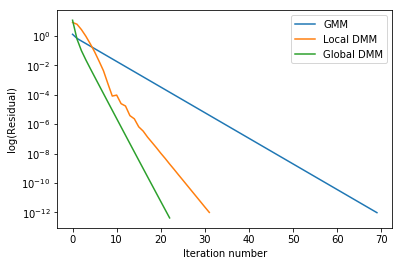

In [14]:
plt.semilogy(linear_gmg.get_gmg_convergence(),label = 'GMM')
plt.semilogy(deep_gmm.get_gmg_convergence(),label= 'Local DMM')
plt.semilogy(DMM_Res,label= 'Global DMM')
plt.xlabel("Iteration number")
plt.ylabel("log(Residual)")
plt.legend()